In [5]:
# Basic Libraries

import numpy as np
import scipy as sp
import sympy as smp
from scipy.integrate import solve_ivp, odeint
import itertools
import mpmath
import opt_einsum as oe
import numba as nb
import symengine as sme
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist

# For Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# For Debugging and Profiling
import snoop
from cProfile import Profile
from pstats import SortKey, Stats
import pyperclip

In [6]:
"""
Reference Paper:
https://doi.org/10.1046/j.1365-8711.1999.02754.x

"""

'\nReference Paper:\nhttps://doi.org/10.1046/j.1365-8711.1999.02754.x\n\n'

In [7]:
%load_ext snoop

In [8]:
%load_ext snakeviz

In [9]:
def get_norm(T, g):
    """
    T should have confuguration either 'u' or 'uu
    Returned Configuration: Scalar
    """
    if T.ndim == 2:
        return np.einsum("ua,vb,ab,uv->", g, g, T, T)

    else:
        return np.einsum("ab,a,b->", g, T, T)

In [6]:
def levi_civita_symbol(dim=4):
    """
    Define Levi Cevita Tensor
    Config: uuuu
    """

    arr = np.zeros(tuple([dim for _ in range(dim)]))
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = 1
        arr[x] = int(np.linalg.det(mat))
    return arr

In [7]:
# @snoop
def levi_civita_tensor(gk):
    #! uuuu
    epsu = levi_civita_symbol()
    det_g = np.linalg.det(gk)
    return epsu / np.sqrt(-(det_g))

In [8]:
def cov_metric_tensor(r, theta, a, M=1.0):
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: ll
    """
    #! Correction Added Mass term in the symbols
    g = np.zeros((4, 4), dtype=type(r))

    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    g[0, 0] = -(1.0 - 2.0 * M * r / Sigma)
    g[1, 1] = Sigma / Delta
    g[2, 2] = Sigma
    g[3, 3] = (
        np.sin(theta) ** 2
        * ((r**2 + a**2) ** 2 - Delta * a**2 * np.sin(theta) ** 2)
        / Sigma
    )
    g[0, 3] = -2.0 * a * M * r * np.sin(theta) ** 2 / Sigma
    g[3, 0] = g[0, 3]

    # return g.astype(float)
    return g

In [9]:
def cot_metric_tensor(r, theta, a, M=1.0):
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: uu
    """
    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    denom = Delta * np.sin(theta) ** 2

    g = np.zeros((4, 4), dtype=type(r))
    g[0, 0] = (
        -(
            np.sin(theta) ** 2
            * ((r**2 + a**2) ** 2 - Delta * a**2 * np.sin(theta) ** 2)
            / Sigma
        )
        / denom
    )

    g[1, 1] = Delta / Sigma

    g[2, 2] = 1.0 / Sigma

    # g[3, 3] = -(-(1.0 - 2.0 * r / Sigma)) / denom
    #! Corrected the g[3,3] term below
    g[3, 3] = (Delta - a**2 * np.sin(theta) ** 2) / (denom * Sigma)

    g[0, 3] = (-2.0 * a * M * r * np.sin(theta) ** 2 / Sigma) / denom

    g[3, 0] = g[0, 3]

    return g.astype(float)
    # return g

In [10]:
#!Corrected g[3,3] component in above code

In [11]:
def kerr_christoffel(r, theta, a, M=1.0):
    """
    Function to give the christoffel symbols for kerr metric.
    The christoffel symbols are given as \Gamma ^i _{jk}

    From Reference Paper, Appendix
    Config: ull
    """

    cs = np.zeros((4, 4, 4), dtype=type(r))

    # Definitions
    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    cs[3, 0, 1] = M * (2 * r**2 - Sigma) / (Delta * Sigma**2) * a
    cs[0, 0, 1] = (
        M * (r**2 + a**2) * (r**2 - a**2 * np.cos(theta) ** 2) / (Sigma**2 * Delta)
    )

    cs[3, 0, 2] = -2 * M * a * r * (np.cos(theta) / np.sin(theta)) / (Sigma**2)
    cs[0, 0, 2] = -2 * M * a**2 * r * np.sin(theta) * np.cos(theta) / Sigma**2

    cs[0, 1, 3] = (
        -M
        * a
        * (2 * r**2 * (r**2 + a**2) + Sigma * (r**2 - a**2))
        * np.sin(theta) ** 2
        / (Delta * Sigma**2)
    )

    cs[3, 1, 3] = (
        r * Sigma * (Sigma - 2 * M * r)
        - M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2
    ) / (Delta * Sigma**2)

    cs[0, 2, 3] = M * a**3 * r * np.sin(theta) ** 2 * np.sin(2 * theta) / Sigma**2

    cs[3, 2, 3] = (
        (np.cos(theta) / np.sin(theta))
        * (Sigma**2 + 2 * M * a**2 * r * np.sin(theta) ** 2)
        / Sigma**2
    )

    cs[1, 0, 0] = M * Delta * (2 * r**2 - Sigma) / Sigma**3

    cs[1, 0, 3] = -cs[1, 0, 0] * a * np.sin(theta) ** 2

    cs[2, 0, 0] = -M * a * r * np.sin(2 * theta) / Sigma**3 * a
    cs[2, 0, 3] = (
        2.0 * M * r * a * (r**2 + a**2) * np.sin(theta) * np.cos(theta) / Sigma**3
    )

    cs[1, 1, 1] = r / Sigma + (M - r) / Delta

    cs[1, 2, 2] = -r * Delta / Sigma
    cs[2, 1, 2] = -cs[1, 2, 2] / Delta

    cs[1, 1, 2] = cs[2, 2, 2] = -(a**2) * np.sin(2 * theta) / (2 * Sigma)
    cs[2, 1, 1] = -cs[1, 1, 2] / Delta

    cs[1, 3, 3] = (
        -Delta
        * (r * Sigma**2 - M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**3
    )

    cs[2, 3, 3] = (
        -(Delta * Sigma**2 + 2 * M * r * (r**2 + a**2) ** 2)
        * np.sin(2 * theta)
        / (2 * Sigma**3)
    )

    cs[0, 1, 0] = cs[0, 0, 1]
    cs[0, 2, 0] = cs[0, 0, 2]
    cs[0, 3, 1] = cs[0, 1, 3]
    cs[0, 3, 2] = cs[0, 2, 3]

    cs[1, 3, 0] = cs[1, 0, 3]
    cs[1, 2, 1] = cs[1, 1, 2]

    cs[2, 3, 0] = cs[2, 0, 3]
    cs[2, 2, 1] = cs[2, 1, 2]

    cs[3, 1, 0] = cs[3, 0, 1]
    cs[3, 2, 0] = cs[3, 0, 2]
    cs[3, 3, 1] = cs[3, 1, 3]
    cs[3, 3, 2] = cs[3, 2, 3]

    # return symmetrize(arr=cs)+np.zeros((4,4,4))
    return cs + np.zeros((4, 4, 4))
    # return cs

In [12]:
#! Made the above compatible for the limiting cases like Minkowski and Schwarschild.
#! Also added Mass term above

In [13]:
def kerr_riemann_tensor(r, theta, a, M=1.0, config="ulll"):
    """
    Define variables

    Components of the Riemann tensor for Kerr Metric
    From Reference Paper, Appendix
    The Configuration is ulll
    """

    rijkl = np.zeros((4, 4, 4, 4), dtype=type(r))

    # Definitions
    Delta = a**2 - 2.0 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    rijkl[0, 0, 0, 3] = (
        2.0
        * M**2
        * np.sin(theta) ** 2
        * a
        * r**2
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / Sigma**4
    )

    rijkl[0, 0, 1, 2] = (
        -2.0
        * M**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * r
        * np.cos(theta)
        * a**2
        * np.sin(theta)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 0, 1] = (
        M
        * r
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 0, 2] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2 * M * r)
        * a**2
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 1, 3] = (
        3.0
        * M
        * np.sin(theta) ** 2
        * a
        * r
        * (r**2 + a**2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 2, 3] = (
        -M
        * np.cos(theta)
        * np.sin(theta)
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (2.0 * (r**2 + a**2) ** 2 + a**2 * np.sin(theta) ** 2 * Delta)
        / (Sigma**3 * Delta)
    )

    # Antisymmetric under exchange of last two indices.
    rijkl[0, 0, 3, 0] = -rijkl[0, 0, 0, 3]
    rijkl[0, 0, 2, 1] = -rijkl[0, 0, 1, 2]
    rijkl[0, 1, 1, 0] = -rijkl[0, 1, 0, 1]
    rijkl[0, 1, 2, 0] = -rijkl[0, 1, 0, 2]
    rijkl[0, 1, 3, 1] = -rijkl[0, 1, 1, 3]
    rijkl[0, 1, 3, 2] = -rijkl[0, 1, 2, 3]

    #! -------------------------------------------------------------------------------------#

    rijkl[0, 2, 0, 1] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4 * M * r)
        * a**2
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )
    rijkl[0, 2, 0, 2] = (
        -M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2 * a**2 * np.sin(theta) ** 2)
        / Sigma**3
    )
    rijkl[0, 2, 1, 3] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * ((a**2 + r**2) ** 2 + 2.0 * a**2 * np.sin(theta) ** 2 * Delta)
        * a
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )
    rijkl[0, 2, 2, 3] = (
        -3.0
        * M
        * np.sin(theta) ** 2
        * r
        * a
        * (a**2 + r**2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / Sigma**3
    )
    rijkl[0, 3, 0, 3] = (
        -np.sin(theta) ** 2
        * M
        * r
        * (r**2 + 3 * a**2 * np.sin(theta) ** 2 - 3 * a**2)
        * ((a**2 + r**2) ** 2 - a**2 * np.sin(theta) ** 2 * Delta)
        / Sigma**4
    )
    rijkl[0, 3, 1, 2] = (
        (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * M
        * ((a**2 + r**2) ** 2 - a**2 * np.sin(theta) ** 2 * Delta)
        * a
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )

    # Symmetries
    rijkl[0, 2, 1, 0] = -rijkl[0, 2, 0, 1]
    rijkl[0, 2, 2, 0] = -rijkl[0, 2, 0, 2]
    rijkl[0, 2, 3, 1] = -rijkl[0, 2, 1, 3]
    rijkl[0, 2, 3, 2] = -rijkl[0, 2, 2, 3]
    rijkl[0, 3, 3, 0] = -rijkl[0, 3, 0, 3]
    rijkl[0, 3, 2, 1] = -rijkl[0, 3, 1, 2]

    #! ------------------------------------------------------------------------------#

    rijkl[1, 0, 0, 1] = (
        r
        * M
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (a**2 * np.sin(theta) ** 2 + 2.0 * Delta)
        / Sigma**4
    )
    rijkl[1, 0, 0, 2] = (
        -3.0
        * M
        * Delta
        * a**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.sin(theta)
        * np.cos(theta)
        / Sigma**4
    )
    rijkl[1, 0, 1, 3] = (
        r
        * M
        * a
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[1, 0, 2, 3] = (
        -a
        * M
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * Delta
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[1, 2, 0, 3] = (
        -np.cos(theta)
        * M
        * np.sin(theta)
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * Delta
        / Sigma**3
    )
    rijkl[1, 2, 1, 2] = -M * r * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / Sigma**2
    rijkl[1, 3, 0, 1] = (
        -np.sin(theta) ** 2
        * M
        * r
        * a
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        / Sigma**4
    )
    rijkl[1, 3, 0, 2] = (
        a
        * M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * np.sin(theta) ** 2)
        * Delta
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[1, 3, 1, 3] = (
        -np.sin(theta) ** 2
        * M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * ((r**2 + a**2) ** 2 + 2.0 * a**2 * Delta * np.sin(theta) ** 2)
        / Sigma**4
    )
    rijkl[1, 3, 2, 3] = (
        3.0
        * M
        * a**2
        * (r**2 + a**2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * Delta
        * np.cos(theta)
        * np.sin(theta) ** 3
        / Sigma**4
    )

    # Symmetries
    rijkl[1, 0, 1, 0] = -rijkl[1, 0, 0, 1]
    rijkl[1, 0, 2, 0] = -rijkl[1, 0, 0, 2]
    rijkl[1, 0, 3, 1] = -rijkl[1, 0, 1, 3]
    rijkl[1, 0, 3, 2] = -rijkl[1, 0, 2, 3]
    rijkl[1, 2, 3, 0] = -rijkl[1, 2, 0, 3]
    rijkl[1, 2, 2, 1] = -rijkl[1, 2, 1, 2]
    rijkl[1, 3, 1, 0] = -rijkl[1, 3, 0, 1]
    rijkl[1, 3, 2, 0] = -rijkl[1, 3, 0, 2]
    rijkl[1, 3, 3, 1] = -rijkl[1, 3, 1, 3]
    rijkl[1, 3, 3, 2] = -rijkl[1, 3, 2, 3]

    #! -------------------------------------------------------------------------------------#

    rijkl[2, 0, 0, 1] = (
        -3.0
        * M
        * a**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.sin(theta)
        * np.cos(theta)
        / Sigma**4
    )
    rijkl[2, 0, 0, 2] = (
        -M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (2.0 * a**2 * np.sin(theta) ** 2 + Delta)
        / Sigma**4
    )
    rijkl[2, 0, 1, 3] = (
        -a
        * M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * np.sin(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[2, 0, 2, 3] = (
        -M
        * r
        * a
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[2, 1, 0, 3] = (
        M
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**3
    )
    rijkl[2, 1, 1, 2] = (
        M * r * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / (Delta * Sigma**2)
    )
    rijkl[2, 3, 0, 1] = (
        M
        * a
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[2, 3, 0, 2] = (
        M
        * r
        * a
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[2, 3, 1, 3] = (
        3.0
        * M
        * a**2
        * (r**2 + a**2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta) ** 3
        / Sigma**4
    )
    rijkl[2, 3, 2, 3] = (
        M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (2.0 * (r**2 + a**2) ** 2 + a**2 * Delta * np.sin(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )

    # Symmetries
    rijkl[2, 0, 1, 0] = -rijkl[2, 0, 0, 1]
    rijkl[2, 0, 2, 0] = -rijkl[2, 0, 0, 2]
    rijkl[2, 0, 3, 1] = -rijkl[2, 0, 1, 3]
    rijkl[2, 0, 3, 2] = -rijkl[2, 0, 2, 3]
    rijkl[2, 1, 3, 0] = -rijkl[2, 1, 0, 3]
    rijkl[2, 1, 2, 1] = -rijkl[2, 1, 1, 2]
    rijkl[2, 3, 1, 0] = -rijkl[2, 3, 0, 1]
    rijkl[2, 3, 2, 0] = -rijkl[2, 3, 0, 2]
    # rijkl[2, 3, 2, 1] = -rijkl[2, 3, 1, 2]
    rijkl[2, 3, 3, 1] = -rijkl[2, 3, 1, 3]
    rijkl[2, 3, 3, 2] = -rijkl[2, 3, 2, 3]

    #! --------------------------------------------------------------------------#

    rijkl[3, 0, 1, 2] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (a**2 * np.sin(theta) ** 2 - Delta)
        * a
        * (np.cos(theta) / np.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 0, 1] = (
        3.0 * M * r * a * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / (Delta * Sigma**3)
    )
    rijkl[3, 1, 0, 2] = (
        -M
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (2.0 * a**2 * np.sin(theta) ** 2 + Delta)
        * (np.cos(theta) / np.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 1, 3] = (
        M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * np.sin(theta) ** 2)
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 2, 3] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * a**2
        * np.sin(theta)
        * np.cos(theta)
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 0, 1] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (a**2 * np.sin(theta) ** 2 + 2.0 * Delta)
        * a
        * (np.cos(theta) / np.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 0, 2] = (
        -M * 3.0 * r * a * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / Sigma**3
    )
    rijkl[3, 2, 1, 3] = (
        -M
        * a**2
        * (3 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        * np.sin(theta)
        * np.cos(theta)
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 2, 3] = (
        -M
        * r
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / Sigma**3
    )
    rijkl[3, 3, 0, 3] = (
        -2.0
        * M**2
        * a
        * r**2
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[3, 3, 1, 2] = (
        2.0
        * M**2
        * r
        * a**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / (Delta * Sigma**3)
    )

    # Symmetries
    rijkl[3, 0, 2, 1] = -rijkl[3, 0, 1, 2]
    rijkl[3, 1, 1, 0] = -rijkl[3, 1, 0, 1]
    rijkl[3, 1, 2, 0] = -rijkl[3, 1, 0, 2]
    rijkl[3, 1, 3, 1] = -rijkl[3, 1, 1, 3]
    rijkl[3, 1, 3, 2] = -rijkl[3, 1, 2, 3]
    rijkl[3, 2, 1, 0] = -rijkl[3, 2, 0, 1]
    rijkl[3, 2, 2, 0] = -rijkl[3, 2, 0, 2]
    rijkl[3, 2, 3, 1] = -rijkl[3, 2, 1, 3]
    rijkl[3, 2, 3, 2] = -rijkl[3, 2, 2, 3]
    rijkl[3, 3, 3, 0] = -rijkl[3, 3, 0, 3]
    rijkl[3, 3, 2, 1] = -rijkl[3, 3, 1, 2]

    #!---------------------------------------------------------------------#

    part1 = a**2 + 2 * r * (-2 * M + r) + a**2 * np.cos(2 * theta)
    part2 = 3 * a**2 - 2 * r**2 + 3 * a**2 * np.cos(2 * theta)
    part3 = (a**2 + 2 * r**2 + a**2 * np.cos(2 * theta)) ** 4
    # Calculating Rtensor elements

    # rijkl[3, 0, 0, 3] =  (part1 + part2 + part3 + part4) / (Sigma**5)
    rijkl[3, 0, 0, 3] = 4 * M * r * part1 * part2 / part3
    rijkl[3, 0, 3, 0] = -rijkl[3, 0, 0, 3]

    # return rijkl
    if config == "ulll":
        return rijkl + np.zeros((4, 4, 4, 4))

    elif config == "llll":
        gk = cov_metric_tensor(r=r, theta=theta, a=a, M=M)
        return np.einsum("ij,jklm->iklm", gk, rijkl) + np.zeros((4, 4, 4, 4))

    # elif config=="lluu":
    #     #!Config: lluu
    #     gkinv = cot_metric_tensor(r=r, theta=theta, a=a, M=M)
    #     gk = cov_metric_tensor(r=r, theta=theta, a=a, M=M)
    #     rllll = np.einsum("ij,jklm->iklm", gk, rijkl)

    #     return np.einsum("kjlm,la,mb->kjab", rllll, gkinv, gkinv)

    else:
        return "Invalid String"

In [14]:
#! Corrected and Verified the Function above
#! Added Mass Terms to it

In [15]:
def spintensor(levi, pvector, svector, gk, m):

    p_vectorl = np.einsum("ij,j->i", gk, pvector)  #! Lower the pvector
    s_vectorl = np.einsum("ij,j->i", gk, svector)  #! Lower the svector

    #! Using above definition
    return np.einsum("uvab,a,b->uv", levi, p_vectorl, s_vectorl) / m

In [16]:
def metric_D(r, theta, a, M=1.0):
    dgkt = np.zeros((4, 4), dtype=type(r))
    dgkp = np.zeros((4, 4), dtype=type(r))

    denom = (r**2 + a**2 * np.cos(theta) ** 2) ** 2

    dgkt[1, 0] = M * (a**2 - 2 * r**2 + a**2 * np.cos(2 * theta)) / denom
    dgkt[1, 3] = (
        -(2 * a * M * (-(r**2) + a**2 * np.cos(theta) ** 2) * np.sin(theta) ** 2)
        / denom
    )
    dgkt[2, 0] = 2 * a**2 * M * r * np.sin(2 * theta) / denom
    dgkt[2, 3] = -2 * a * M * r * (r**2 + a**2) * np.sin(2 * theta) / denom

    dgkp[1, 0] = (
        -2
        * a
        * M
        * (-(r**2) + a**2 * np.cos(theta) ** 2)
        * np.sin(theta) ** 2
        / denom
    )

    dgkp[1, 3] = (
        2
        * np.sin(theta) ** 2
        * (
            np.cos(theta) ** 2
            * (2 * a**2 * r * (a**2 + r**2) + a**4 * (M - r) * np.sin(theta) ** 2)
            + r * (-(a**4) + r**4 + a**2 * (a**2 - M * r) * np.sin(theta) ** 2)
        )
        / denom
    )

    dgkp[2, 0] = -2 * a * M * r * (a**2 + r**2) * np.sin(2 * theta) / denom
    dgkp[2, 3] = (
        (
            3 * a**6
            + 10 * a**4 * M * r
            + 11 * a**4 * r**2
            + 16 * a**2 * M * r**3
            + 16 * a**2 * r**4
            + 8 * r**6
            + 4
            * a**2
            * (a**2 + 2 * r**2)
            * (a**2 + r * (-2 * M + r))
            * np.cos(2 * theta)
            + a**4 * (a**2 - 2 * M * r + r**2) * np.cos(4 * theta)
        )
        * np.sin(2 * theta)
        / (8 * denom)
    )

    return dgkt.T + np.zeros((4, 4)), dgkp.T + np.zeros((4, 4))

In [17]:
#! Corrected the ordering by transposing the returned matrices

In [18]:
# @snoop
def energy(gk, pvector, Stensor, dgkt):
    pvecl = np.einsum("ij,j->i", gk, pvector)
    term2 = np.einsum("uv,uv->", dgkt, Stensor) / 2.0
    return -pvecl[0] + term2

In [19]:
def angular_momentum(gk, pvector, Stensor, dgkp):
    pvecl = np.einsum("ij,j->i", gk, pvector)
    term2 = np.einsum("uv,uv->", dgkp, Stensor) / 2.0
    return pvecl[3] - term2

<img src="./spinvectortensor.png">


In [20]:
def spin_matrix(sa, pb, epsilon, gk, m):
    """
    Resultant Config: aa
    Input Config: u,u,uu,uuuu
    In Tetrad Basis or Coordinate basis
    Output Config: uu
    Gives same output as above
    """
    # gkinv = sp.linalg.inv(gk)
    #! Changed here
    # return np.einsum("ab,cd,bdkl,k,l->ac",gkinv,gkinv,epsilon,sa,pb)/m
    return np.einsum("bdkl,kx,x,ly,y->bd", epsilon, gk, pb, gk, sa) / m

In [21]:
def momentas(rsol, a, M):
    """
    Function returns the momentas given the current 4-position vectors in covariant fashion
    """

    guv = cov_metric_tensor(r=rsol[1], theta=rsol[2], a=a, M=M)
    p = rsol[4:8]
    return np.einsum("ij,j->i", guv, p)

In [22]:
def to_cartesian(rsol):
    r, t, p = rsol[:, 1], rsol[:, 2], rsol[:, 3]

    x = r * np.sin(t) * np.cos(p)
    y = r * np.sin(t) * np.sin(p)
    z = r * np.cos(t)

    return np.concatenate((x[:, None], y[:, None], z[:, None]), axis=1)

## Something wrong with the function given below.

It does not satisfies tetrad properties


In [23]:
# # @snoop
# def co_tat(r, theta, a, vec, M=1.0, method="to"):
#     """
#     This is a helper function to convert from tetrad basis to
#     coordinate basis and vica-verse.

#     The function needs the information on r, theta and a.

#     The method takes argument 'to' or 'from' taking coordinate_tetrad or
#     coordinate_from_tetradv

#     The function takes an array vec. This is a upper indexed four-vector in
#     either of basis.

#     In tetrad basis, the latin indexed are lowered by minkowski metric while
#     the greek index are lowered by the spacetime metric.

#     So, if a vec with configuration 'u' is passed in latin index fashion, the covarint
#     vector in coordinate basis is e^i_mu vec^mu= vec^i

#     Next, to convert from tetrad basis to coordinate basis, we need the inverse of tetrad basis vectors
#     It is given by e_i^mu. Hence, if a vec with configuration 'u' is passed as vec^i, the resultant coordinate basis
#     vector is e_i^mu vec^i=vec^mu
#     """
#     # Definitions
#     Delta = a**2 - 2.0 * M * r + r**2
#     # scA = (r**2 + a**2) ** 2 - Delta * a**2 * np.sin(theta) ** 2
#     # omega_k = 2 * M * a * r / scA
#     Sigma = r**2 + a**2 * np.cos(theta) ** 2

#     e0 = (
#         np.array(
#             [
#                 [
#                     np.sqrt(Delta / Sigma),
#                     0.0,
#                     0.0,
#                     -a * np.sin(theta) ** 2 * np.sqrt(Delta / Sigma),
#                 ]
#             ]
#         )
#         .astype(np.float64)
#         .T
#     )

#     e1 = np.array([[0.0, np.sqrt(Sigma / Delta), 0.0, 0.0]]).astype(np.float64).T
#     e2 = np.array([[0.0, 0.0, np.sqrt(Sigma), 0.0]]).astype(np.float64).T
#     e3 = (
#         np.array(
#             [
#                 [
#                     -a * np.sin(theta) / np.sqrt(Sigma),
#                     0.0,
#                     0.0,
#                     (r**2 + a**2) * np.sin(theta) / np.sqrt(Sigma),
#                 ]
#             ]
#         )
#         .astype(np.float64)
#         .T
#     )

#     tet = np.hstack([e0, e1, e2, e3])
#     return tet

#     #! Now for tetrad to Coordinate basis
#     tet_inv = sp.linalg.inv(tet)

#     # coo_vec = np.einsum("ij,j->i", tet_inv, vec)

#     if method == "to":
#         if vec.ndim == 1:
#             return np.einsum("ij,i->j", tet, vec)
#         else:
#             return np.einsum("ij,kl,ik->jl", tet, tet, vec)

#     elif method == "from":
#         if vec.ndim == 1:
#             return np.einsum("ij,i->j", tet_inv, vec)
#         else:
#             return np.einsum("ij,kl,ik->jl", tet_inv, tet_inv, vec)

In [24]:
# gk=cov_metric_tensor(6.0,np.pi/2.0,0.0,1.0)
# tet = co_tat(6.0, np.pi / 2.0, 0.0, gk, 1.0, "to")

In [25]:
# np.einsum("u,v->uv",tet[:,0],tet[:,1])

In [26]:
# -------------New Code---------

### Check weather the below Functions give correct Output or not in Mathematica

In [27]:
def calculate_four_momentum(pvector, uvector, svector, cs, Riemann, levi_mixed, m):
    correction = np.einsum(
        "abps,psuv,b,u,v->a", Riemann, levi_mixed, uvector, svector, pvector,optimize=True
    ) / (2.0 * m)
    dp = correction - np.einsum("auv,u,v->a", cs, pvector, uvector)

    return dp

In [28]:
# @snoop
def rhs23(vmu, su, ps, cs, rulll, epsilon_mixed, m):

    term1 = np.einsum("uvab,abps,v,p,s->u", rulll, epsilon_mixed, vmu, su, ps,optimize=True) / (
        2.0 * m
    )
    term2 = np.einsum("usp,s,p->u", cs, ps, vmu)

    return term1 - term2

In [29]:
def calculate_four_spin(pvector, uvector, svector, cs, Riemann_covar, levi_mixed, m):
    correction = np.einsum(
        "a,gbps,psuv,g,b,u,v->a",
        pvector,
        Riemann_covar,
        levi_mixed,
        svector,
        uvector,
        svector,
        pvector,optimize=True
    ) / (2.0 * m**3)
    ds = correction - np.einsum("auv,u,v->a", cs, svector, uvector)

    return ds

In [30]:
def rhs24(vmu, su, ps, cs, rllll, epsilon_mixed, m):

    term1 = np.einsum(
        "a,gbps,psuv,g,b,u,v->a", ps, rllll, epsilon_mixed, su, vmu, su, ps,optimize=True
    ) / (2.0 * m**3)

    term2 = np.einsum("usp,s,p->u", cs, su, vmu)

    return term1 - term2

In [31]:
# @snoop
def calculate_four_velocity(pvector, Stensor, Riemann_cov, m):
    scalar_divisor = np.einsum("uvps,uv,ps->", Riemann_cov, Stensor, Stensor,optimize=True) / 4.0
    correction = np.einsum(
        "ab,bguv,g,uv->a", Stensor, Riemann_cov, pvector, Stensor,optimize=True
    ) / (2.0 * (m**2 + scalar_divisor))
    dx = (pvector + correction) / (m)
    # Vsq = np.einsum("uv,u,v->",gk,dx,dx)

    # Pv= -np.sqrt(-1/Vsq)
    Pv = 1.0
    dx = dx * Pv

    return dx

In [32]:
def rhs27(umu, Stensor, rllll, m):
    # _,r,theta,_=y

    delta = np.einsum("abgs,ab,gs->", rllll, Stensor, Stensor,optimize=True) / 4.0
    num = np.einsum("uv,vlps,l,ps->u", Stensor, rllll, umu, Stensor,optimize=True)

    correction = num / (2.0 * (delta + m**2))

    dx = umu + correction

    # N= np.einsum("ij,i,j->",gk,dx,umu)
    return dx

In [33]:
def MPD(t, y, p):
    t, r, theta, phi, pt, pr, ptheta, pphi, st, sr, stheta, sphi = y

    a, m, M = p

    # xvector=y[:4]
    pvector = y[4:8]  #! p^u
    svector = y[8:]  #! s^u

    gk = cov_metric_tensor(r, theta, a, M)  #! g_{ij}
    cs = kerr_christoffel(r, theta, a, M)  #! G^i_{jk}

    Riemann = kerr_riemann_tensor(r, theta, a, M, "ulll")  #! R^a_{bcd}

    Riemann_cov = np.einsum("ul,lvps->uvps", gk, Riemann)  #! R_{abcd}

    levi = levi_civita_tensor(gk)  #! e^{abcd}
    levi_mixed = np.einsum("psxy,xu,yv->psuv", levi, gk, gk)  #! e^{ps}_{uv}

    stensor = spintensor(levi, pvector=pvector, svector=svector, gk=gk, m=m)  #! S^{uv}

    uvector = calculate_four_velocity(
        pvector=pvector, Stensor=stensor, Riemann_cov=Riemann_cov, m=m
    )  #!dx^mu

    dp = calculate_four_momentum(
        pvector=pvector,
        uvector=uvector,
        svector=svector,
        cs=cs,
        Riemann=Riemann,
        levi_mixed=levi_mixed,
        m=m,
    )
    #!dp^{mu}

    ds = calculate_four_spin(
        pvector=pvector,
        uvector=uvector,
        svector=svector,
        cs=cs,
        Riemann_covar=Riemann_cov,
        levi_mixed=levi_mixed,
        m=m,
    )
    #!ds^{mu}

    dy = np.zeros_like(y)

    dy[0:4] = uvector
    dy[4:8] = dp
    dy[8:] = ds

    return dy

In [34]:
# @snoop
def mpd(t, y, p):
    """
    Solve the MPD Equations Given the Initial Conditions
    """
    a, m, M = p
    # if:
    #     dy = np.zeros_like(y, dtype=np.complex128)
    # else:
    #     dy=np.zeros_like(y,dtype=np.float64)
    dy = np.zeros_like(y, dtype=type(y[0]))
    ps = y[4:8]
    su = y[8:]

    gk = cov_metric_tensor(r=y[1], theta=y[2], a=a, M=M)
    cs = kerr_christoffel(r=y[1], theta=y[2], a=a, M=M)  #! G^i_{jk}

    levi = levi_civita_tensor(gk)
    levi_mixed = np.einsum("psab,au,bv->psuv", levi, gk, gk)

    rulll = kerr_riemann_tensor(y[1], y[2], a, M, "ulll")
    rllll = np.einsum("ij,jvps->ivps", gk, rulll)

    Stensor = spintensor(levi, ps, su, gk, m)

    vmu = rhs27(umu=ps / m, Stensor=Stensor, rllll=rllll, m=m)

    dp = rhs23(vmu=vmu, su=su, ps=ps, cs=cs, rulll=rulll, epsilon_mixed=levi_mixed, m=m)

    ds = rhs24(vmu=vmu, su=su, ps=ps, cs=cs, rllll=rllll, epsilon_mixed=levi_mixed, m=m)

    dy[:4] = vmu
    dy[4:8] = dp
    dy[8:] = ds

    return dy

In [35]:
M = 1.0
m = 1e0

S = 1.0 * m * M
E = 0.9328 * m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = np.pi / 3.0
phi0 = 0.0
a0 = 0.8 * M

S1 = 0.0
S3 = 0.0

P2 = 0.0

In [36]:
gk = cov_metric_tensor(r=r0, theta=theta0, a=a0, M=M)
gkinv = cot_metric_tensor(r=r0, theta=theta0, a=a0, M=M)

In [37]:
cs = kerr_christoffel(r=r0, theta=theta0, a=a0, M=M)

In [38]:
rllll = kerr_riemann_tensor(r=r0, theta=theta0, a=a0, M=M, config="llll")
rulll = kerr_riemann_tensor(r=r0, theta=theta0, a=a0, M=M, config="ulll")

In [39]:
print(gkinv)

[[-1.49347776  0.          0.         -0.01077462]
 [ 0.          0.68141593  0.          0.        ]
 [ 0.          0.          0.02765487  0.        ]
 [-0.01077462  0.          0.          0.03615485]]


In [40]:
p0, p3, p1 = smp.symbols("p^0,p^3,p^1")
#!In coordinate basis p^mu

In [41]:
p_coordu = np.array([p0, p1, P2, p3])
#!In coordinate basis p^i

In [42]:
s_coordu = np.array([0.0, S1, S / np.sqrt(gk[2, 2]), S3])
#!In coordinate basis, S^p

In [43]:
s_coordu

array([0.        , 0.        , 0.16629753, 0.        ])

#### g_uv S^v S^u= S**2

In [44]:
get_norm(s_coordu, gk)

1.0000000000000002

#### Constraint Equation g_uv p^v S^u=0

In [45]:
np.einsum("ij,j,i->", gk, p_coordu, s_coordu)

0

In [46]:
# Definitions
Delta = a0**2 - 2 * M * r0 + r0**2
Sigma = r0**2 + a0**2 * np.cos(theta0) ** 2

In [47]:
levi = levi_civita_tensor(gk)
#!epsilon^{uuuu}

In [48]:
# Suv = co_tat(r0, theta=theta0, a=a0, vec=Sab, method="from")
Suv = spintensor(levi=levi, pvector=p_coordu, svector=s_coordu, gk=gk, m=m)
#! S^{mu nu}

In [49]:
print(Suv[1, 3])

0.12829911644804*p^0 + 0.0382348360275615*p^3


In [50]:
dgkt, dgkp = metric_D(r0, theta0, a0, M)
#! dg_{t mu nu},dg_{phi mu nu}

In [51]:
Suv

array([[0, 0.0382348360275615*p^0 - 5.29975611167098*p^3, 0,
        0.281801224378605*p^1],
       [-0.0382348360275615*p^0 + 5.29975611167098*p^3, 0, 0,
        0.12829911644804*p^0 + 0.0382348360275615*p^3],
       [0, 0, 0, 0],
       [-0.281801224378605*p^1,
        -0.12829911644804*p^0 - 0.0382348360275615*p^3, 0, 0]],
      dtype=object)

In [52]:
eq210a = energy(gk, p_coordu, Suv, dgkt) - E

In [53]:
eq210a

0.664983553366455*p^0 + 0.343753255816357*p^3 - 0.9328

In [54]:
eq210b = angular_momentum(gk, p_coordu, Suv, dgkp) - Jz

In [55]:
eq210b

0.376336156036052*p^0 + 27.8583087156138*p^3 - 2.8

In [56]:
eq533 = get_norm(T=p_coordu, g=gk) + m**2

In [57]:
eq533.expand()

-0.668141592920354*p^0**2 - 0.398230088495575*p^0*p^3 + 1.46753246753247*p^1**2 + 27.5994690265487*p^3**2 + 1.0

In [58]:
eq210a, eq210b, eq533

(0.664983553366455*p^0 + 0.343753255816357*p^3 - 0.9328,
 0.376336156036052*p^0 + 27.8583087156138*p^3 - 2.8,
 -0.668141592920354*p^0**2 - 0.398230088495575*p^0*p^3 + 1.46753246753247*p^1**2 + 27.5994690265487*p^3**2 + 1.0)

In [59]:
# smp.nsolve([eq533, eq210a, eq210b], [p0, p1, p3],[1e-5,1e-5,1e-5])

In [60]:
def solve_eq0(p_0, p_1, p_3):
    f = sme.lambdify([p0, p1, p3], [eq210a, eq210b, eq533])
    return np.array(f(p_0, p_1, p_3))

In [61]:
solve_eq0(m, m, m)

array([ 0.07593681, 25.43464487, 29.00062981])

In [62]:
smp.solve([eq210a, eq210b, eq533], [p0, p1, p3])

[(1.36028423587838, -0.253925040089299, 0.0821326191374529),
 (1.36028423587838, 0.253925040089299, 0.0821326191374529)]

In [63]:
np0, np1, np3 = smp.solve([eq210a, eq210b, eq533], [p0, p1, p3])[1]

In [64]:
solve_eq0(np0, np1, np3)

array([ 2.11636264e-16,  3.55271368e-15, -5.55111512e-16])

In [65]:
np0, np1, np3

(1.36028423587838, 0.253925040089299, 0.0821326191374529)

In [66]:
# get_norm(T=np.array([np0,np1,P2,np3]),g=eta)

In [67]:
# np_coordu=np.array(smp.Matrix(p_coordu).subs([(p0,np0),(p1,np1),(p3,np3)])).flatten().astype(float)
np_coordu = np.array([np0, np1, P2, np3]).astype(float)

In [68]:
ns_coordu = (
    np.array(smp.Matrix(s_coordu).subs([(p0, np0), (p1, np1), (p3, np3)]))
    .flatten()
    .astype(float)
)
# ns_coordu= np.array([])

In [69]:
ns_coordu

array([0.        , 0.        , 0.16629753, 0.        ])

In [70]:
get_norm(T=np_coordu, g=gk)

-1.0

In [71]:
levi = levi_civita_tensor(gk)

In [72]:
Suv = spintensor(levi, np_coordu, ns_coordu, gk, m)

In [73]:
print(Suv)

[[ 0.         -0.38327261  0.          0.07155639]
 [ 0.38327261  0.          0.          0.17766359]
 [ 0.          0.          0.          0.        ]
 [-0.07155639 -0.17766359  0.          0.        ]]


In [74]:
angular_momentum(gk, np_coordu, Suv, dgkp)

2.8000000000000034

In [75]:
# vmu0=rhs27(y=[0.,r0,theta0,phi0],umu=p_coordu/m,su=s_coordu,gk=gk,eps=levi_civita_tensor(gk),a=a0,m=m,config='u',M=M)
vmu0 = rhs27(umu=np_coordu / m, Stensor=Suv, rllll=rllll, m=m)

#! Get v^mu according to equation 2.27  in paper

In [76]:
vmu0

array([1.36213363, 0.25418935, 0.        , 0.08294055])

In [77]:
calculate_four_velocity(np_coordu, Suv, rllll, m)

array([1.36213363, 0.25418935, 0.        , 0.08294055])

In [78]:
# np0,np1,np2,np3=co_tat(
#     r=r0,
#     theta=theta0,
#     a=a0,
#     vec=np_coordu,
#     method="to",
# )

In [79]:
# N=1/(1-(M*S**2)*(1+3*np3**2/m**2)/r0**3)

In [80]:
# v_tet_theory = np.array(
#     [
#         N * (1 - M * S**2 / r0**3) * np0 / m,
#         N * (1 - M * S**2 / r0**3) * np1 / m,
#         0.0,
#         N * (1 + 2 * M * S**2 / r0**3) * np3 / m,
#     ]
# ).astype(float)

# #!Eq: 2.15-17 in paper

## Check Here

In [81]:
# co_tat(
#     r=r0,
#     theta=theta0,
#     a=a0,
#     vec=v_tet_theory,
#     method="from",
# )  #!v^i

In [82]:
levi_mixed = np.einsum("psxy,xu,yv->psuv", levi, gk, gk)

In [83]:
rhs24(vmu0, ns_coordu, np_coordu, cs, rllll, levi_mixed, m)

array([ 0.00208528,  0.00060961, -0.007014  , -0.00694577])

In [84]:
calculate_four_spin(np_coordu, vmu0, ns_coordu, cs, rllll, levi_mixed, m)

array([ 0.00208528,  0.00060961, -0.007014  , -0.00694577])

### We Checked above functions in Mathematica. The Values agreed in both the codes.

In [85]:
calculate_four_momentum(np_coordu, vmu0, ns_coordu, cs, rulll, levi_mixed, m)

array([-0.02371152, -0.00549826,  0.00258853, -0.00738528])

In [86]:
rhs23(vmu0, ns_coordu, np_coordu, cs, rulll, levi_mixed, m)

array([-0.02371152, -0.00549826,  0.00258853, -0.00738528])

In [87]:
# @snoop
def get_constants(rsol, gk, a,m, M=1.0):
    _, r, theta, _ = rsol[:4]
    pmuu = rsol[4:8]
    smuu = rsol[8:]

    dgkt, dgkp = metric_D(r, theta=theta, a=a, M=M)

    levi = levi_civita_tensor(gk=gk)  #!'uuuu', tetrad
    # Sab=spin_matrix(sa=si,pb=pi,gk=eta,epsilon=epsilon)
    Suv = spintensor(levi, pmuu, smuu, gk, m)

    E = energy(gk, pmuu, Suv, dgkt)
    Jz = angular_momentum(gk, pmuu, Suv, dgkp)

    mu = get_norm(T=pmuu, g=gk)
    Smag = get_norm(T=smuu, g=gk)

    ps = np.einsum("ij,j,i->", gk, pmuu, smuu)

    return E, Jz, mu, Smag, ps

In [88]:
# In Coordinate basis

In [89]:
#!The initial conditions
#!We pass r0^mu,p^mu and S^mu
y0 = np.array(
    [
        0.0,
        r0,
        theta0,
        phi0,
        np_coordu[0],
        np_coordu[1],
        np_coordu[2],
        np_coordu[3],
        ns_coordu[0],
        ns_coordu[1],
        ns_coordu[2],
        ns_coordu[3],
    ]
).astype(float)

In [90]:
y0

array([0.        , 6.        , 1.04719755, 0.        , 1.36028424,
       0.25392504, 0.        , 0.08213262, 0.        , 0.        ,
       0.16629753, 0.        ])

In [91]:
mpd(0.0, y0, [a0, m, M])

array([ 1.36213363e+00,  2.54189353e-01,  0.00000000e+00,  8.29405457e-02,
       -2.37115214e-02, -5.49825939e-03,  2.58853364e-03, -7.38528191e-03,
        2.08527581e-03,  6.09607552e-04, -7.01400341e-03, -6.94577402e-03])

In [92]:
MPD(0.0, y0, [a0, m, M])

array([ 1.36213363e+00,  2.54189353e-01,  0.00000000e+00,  8.29405457e-02,
       -2.37115214e-02, -5.49825939e-03,  2.58853364e-03, -7.38528191e-03,
        2.08527581e-03,  6.09607552e-04, -7.01400341e-03, -6.94577402e-03])

In [93]:
get_constants(y0, gk, a0,m, M)

(0.9328000000000002, 2.8000000000000034, -1.0, 1.0000000000000002, 0.0)

## Solution of Diffferential Equation

In [94]:
# # @snoop(depth=2)
# def integrate_BulirschStoeir(F, x, y, xStop, tol):
#     def midpoint(F, x, y, xStop, nSteps):
#         h = (xStop - x) / nSteps

#         y0 = y
#         y1 = y0 + h * F(x, y0, a=a0, m=m, M=M)
#         for i in range(nSteps - 1):
#             x = x + h
#             y2 = y0 + 2.0 * h * F(x, y1, a=a0, m=m, M=M)
#             y0 = y1
#             y1 = y2

#         return 0.5 * (y1 + y0 + h * F(x, y2, a=a0,m=m,M=M))

#     def richardson(r, k):
#         for j in range(k - 1, 0, -1):
#             const = (k / (k - 1.0)) ** (2.0 * (k - j))
#             r[j] = (const * r[j + 1] - r[j]) / (const - 1.0)
#         return

#     kMax = 51  ## Indentation problem from here
#     n = len(y)
#     r = np.zeros((kMax, n), dtype=float)

#     # Start with two integration steps
#     nSteps = 2
#     r[1] = midpoint(F, x, y, xStop, nSteps)
#     r_old = r[1].copy()

#     # Increase the number of integration points by 2 and refine result by Richardson extrapolation
#     for k in range(2, kMax):
#         nSteps = 2 * k
#         r[k] = midpoint(F, x, y, xStop, nSteps)
#         richardson(r, k)

#         # Compute RMS change in solution
#         e = np.sqrt(sum((r[1] - r_old) ** 2) / n)

#         # Check for convergence
#         if e < tol:
#             return r[1]
#         r_old = r[1].copy()
#     print("Midpoint method did not converge")


# # Bulirsch-Stoer Algorithm:-

# """ X, Y = bulStoer(F, x, y, xStop, H, tol=1.0e-6).
#     Simplified Bulirsch-Stoer method for solving the
#     initial value problem {y}’ = {F(x,{y})}, where {y} = {y[0],y[1],...y[n-1]}
#     x, y = initial conditions
#     xStop = terminal value of x
#     H = increment of x at which results are stored
#     F = user-supplied function that returns the array F(x,y) = {y’[0],y’[1],...,y’[n-1]} """

# # from numpy import array


# def bulStoer(F, x, y, xStop, H, tol=1.0e-6):
#     X = []
#     Y = []
#     X.append(x)
#     Y.append(y)
#     while x < xStop:
#         H = min(H, xStop - x)
#         y = integrate_BulirschStoeir(F=F, x=x, y=y, xStop=x + H, tol=tol)  # Midpoint method
#         x = x + H
#         X.append(x)
#         Y.append(y)
#     return np.array(X), np.array(Y)


# def printSoln(X, Y, freq):
#     def printHead(n):
#         print("\n        x  ", end=" ")  ## end=" " here
#         for i in range(n):
#             print("      y[", i, "] ", end=" ")  ## end=" " here
#         print()

#     def printLine(x, y, n):
#         print("{:13.4e}".format(x), end=" ")  ## end=" " here
#         for i in range(n):
#             print("{:13.4e}".format(y[i]), end=" ")  ## end=" " here
#         print()

#     m = Y.shape[0]
#     try:
#         n = Y.shape[1]
#     except Exception:
#         n = 1
#     if freq == 0:
#         freq = m
#     printHead(n)
#     for i in range(0, m, freq):
#         printLine(X[i], Y[i], n)
#     if i != m - 1:
#         printLine(X[m - 1], Y[m - 1], n)

In [95]:
# rsol2=bulStoer(mpd,0.0,y0,20.,0.01,1e-13)[1]

In [96]:
def poincare(t, y, *args):
    # return y[3]%np.pi -1.
    if y[0] > 0:
        return y[2] - (np.pi / 2)

    else:
        return y[1]  # Impossible Conditions

In [97]:
p = [a0, m, M]

In [98]:
sol = solve_ivp(
    fun=MPD,
    t_span=[0.0, 10000.0],
    y0=y0,
    method="LSODA",
    t_eval=np.arange(0.0, 10000.0, 1),
    args=(p,),
    rtol=1e-13,
    atol=1e-13,
)

In [99]:
rsol = sol.y.T

In [100]:
# Check for the constants

In [101]:
rsol[-1]

array([ 1.30708712e+04,  8.64298102e+00,  1.74726862e+00,  7.08388205e+02,
        1.20329035e+00,  1.80705209e-01,  1.57668421e-02,  2.98611990e-02,
        2.79340972e-02, -2.10277078e-02,  1.05660020e-01, -4.75438238e-02])

In [102]:
E, Jz, m**2, S**2

(0.9328, 2.8, 1.0, 1.0)

In [103]:
i = -1
gki = cov_metric_tensor(rsol[i][1], rsol[i][2], a0, M)
get_constants(rsol=rsol[i], gk=gki, a=a0,m=m, M=M)[0] - E, get_constants(
    rsol=rsol[i], gk=gki, a=a0,m=m, M=M
)[1] - Jz, get_constants(rsol=rsol[i], gk=gki, a=a0,m=m, M=M)[2] + m**2, get_constants(
    rsol=rsol[i], gk=gki, a=a0,m=m, M=M
)[
    3
] - S**2

(3.0618774182755715e-10,
 1.7204017321859055e-08,
 -2.0948154322297796e-10,
 4.863500713270241e-10)

In [104]:
motconst = np.array(
    [
        get_constants(rsol[i], cov_metric_tensor(rsol[i][1], rsol[i][2], a0, M), a0,m, M)
        - np.array([E, Jz, m**2, S**2, 0.0])
        for i in range(len(rsol))
    ]
)

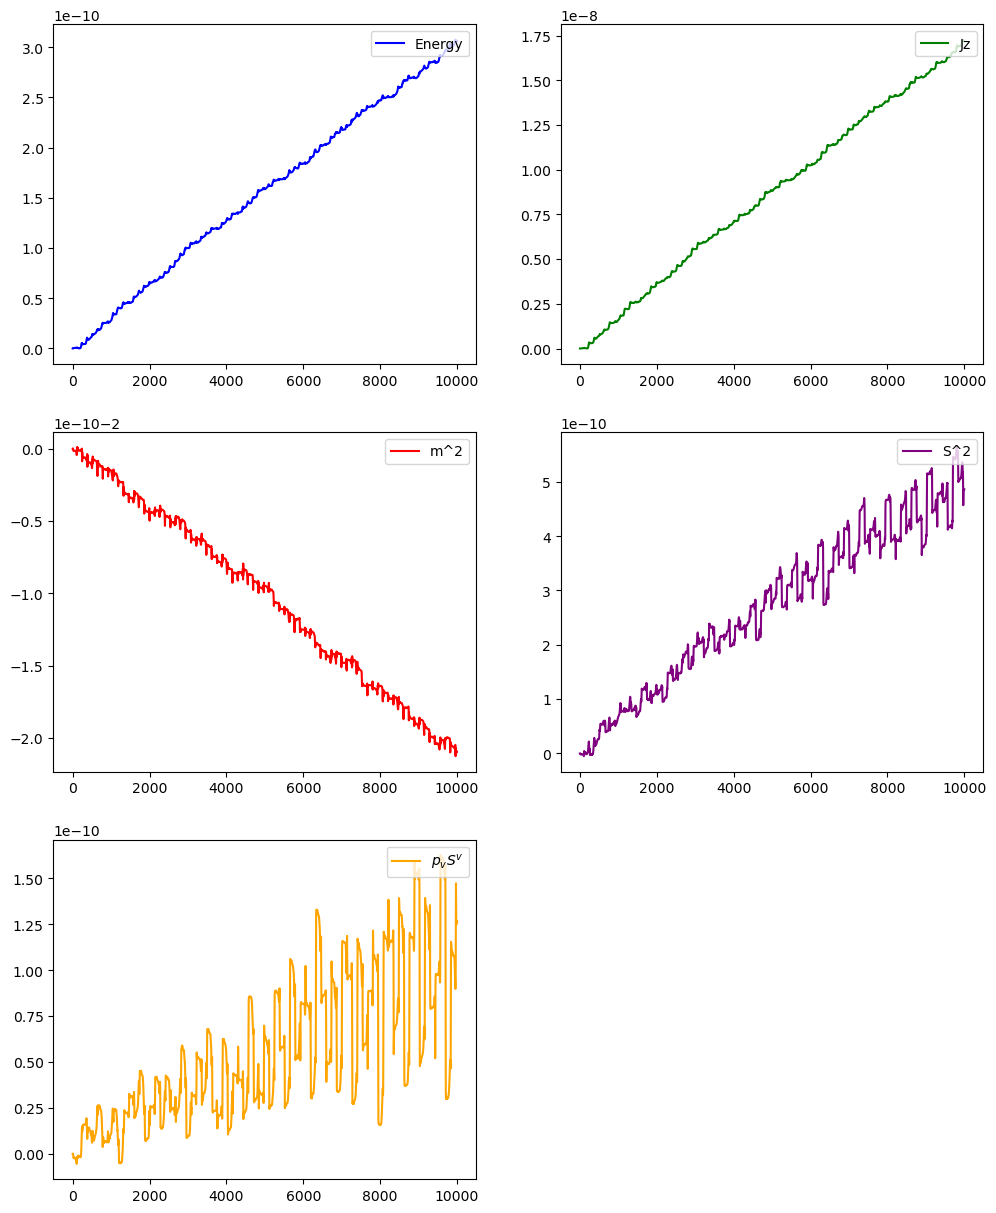

In [105]:
f, ax = plt.subplots(3, 2, figsize=(12, 15))
ax[0, 0].plot(sol.t, motconst[:, 0], label="Energy", color="blue")
ax[0, 1].plot(sol.t, motconst[:, 1], label="Jz", color="green")
ax[1, 0].plot(sol.t, motconst[:, 2], label="m^2", color="red")
ax[1, 1].plot(sol.t, motconst[:, 3], label="S^2", color="purple")
ax[2, 0].plot(sol.t, motconst[:, 4], label=r"$p_v S^v$", color="orange")
ax[0, 0].legend(loc="upper right")
ax[0, 1].legend(loc="upper right")
ax[1, 0].legend(loc="upper right")
ax[1, 1].legend(loc="upper right")
ax[2, 0].legend(loc="upper right")
f.delaxes(ax[2, 1])

In [106]:
crsol = to_cartesian(rsol=rsol)

In [107]:
# fig = go.Figure(
#     data=go.Scatter3d(
#         x=crsol[:, 0],
#         y=crsol[:, 1],
#         z=crsol[:, 2],
#         marker=dict(
#             size=4,
#             color=crsol[:, 2],
#             colorscale="Viridis",
#         ),
#         line=dict(color="darkblue", width=2),
#     )
# )

# fig.update_layout(
#     title=f"Particle motion with the initial conditions E={E:.3E}, Jz={Jz:.3E} and S={S:.3E}",
#     width=800,
#     height=700,
#     autosize=False,
#     scene=dict(
#         camera=dict(
#             up=dict(x=0, y=0, z=1),
#             eye=dict(
#                 x=0,
#                 y=1.0707,
#                 z=1,
#             ),
#         ),
#         aspectratio=dict(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     ),
# )

# # fig.update_traces(line_colorbar_exponentformat="E", selector=dict(type='parcoords'))

# fig.show()

In [108]:
# stop

In [109]:
# poi_points = sol.y_events[0]

In [110]:
# poi_points.shape

In [111]:
# poi_points[1000]

In [112]:
# vr = np.zeros(poi_points[:, 5].shape[0])
# for i in range(len(vr)):
#     gk = cov_metric_tensor(poi_points[i, 1], poi_points[i, 2], a0, M)
#     levi=levi_civita_tensor(gk)
#     Stensor=spintensor(levi,poi_points[i][4:8],poi_points[i][8:],gk,m)
#     rllll=kerr_riemann_tensor(poi_points[i][1],poi_points[i][2],a0,M,"llll")
#     vr[i] = rhs27(
#         y=poi_points[i, :4],
#         umu=poi_points[i, 4:8] / m,
#         Stensor=Stensor,
#         gk=gk,
#         rllll=rllll,
#         m=m,
#     )[1]

In [113]:
# plt.figure(dpi=1200)
# plt.scatter(poi_points[:, 1], vr, s=0.5, c="black")
# plt.title(r"Poincare plot in $\theta = \pi/2$ plane")
# plt.xlabel("r")
# plt.ylabel(r"$V_r$")

## Let us now generalize the model by adding one more constraints

In [114]:
M = 1e0
m = 1e0

S = 1e0 * m * M
E = 0.9328 * m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = np.pi / 2.0
phi0 = 0.0
a0 = 1.0 * M

In [115]:
v_= np.sqrt(M/r0)
abar= a0/M

Epro= (1-2*v_**2+abar*v_**3)/(np.sqrt(1-3*v_**2+2*abar*v_**3))
Eret = (1 - 2 * v_**2 - abar * v_**3) / (np.sqrt(1 - 3 * v_**2 - 2 * abar * v_**3))

ideg=np.pi/30
ecc= 0.01
alpha_ip= 1+np.cos(ideg)
alpha_im = 1 - np.cos(ideg)

# E= 0.5*(alpha_ip*Epro + alpha_im*Eret)
# Jz = np.cos(ideg)*np.sqrt((1-ecc**2)/(2*(1-E)))

In [116]:
E,Jz

(0.9328, 2.8)

In [117]:
gk = cov_metric_tensor(r=r0, theta=theta0, a=a0, M=M)
gkinv = cot_metric_tensor(r=r0, theta=theta0, a=a0, M=M)

In [118]:
cs = kerr_christoffel(r=r0, theta=theta0, a=a0, M=M)

In [119]:
rllll = kerr_riemann_tensor(r=r0, theta=theta0, a=a0, M=M, config="llll")
rulll = kerr_riemann_tensor(r=r0, theta=theta0, a=a0, M=M, config="ulll")

In [120]:
levi = levi_civita_tensor(gk)
#!epsilon^{uuuu}

In [121]:
levi_mixed = np.einsum("psxy,xu,yv->psuv", levi, gk, gk)

In [122]:
dgkt, dgkp = metric_D(r0, theta0, a0, M)

In [123]:
P1 = 1e-2 * m

In [124]:
S1 = 1e-6 * m
S2 = 1e-6 * m

In [125]:
p0, p2, p3 = sme.symbols("p0 p2 p3", real=True)
#!Coordinate Components, 'u'

In [126]:
s0, s3 = sme.symbols("s0 s3", real=True)
#!Coordinate Components, 'u'

In [127]:
gpcoordu = np.array([p0, P1, p2, p3])
gscoordu = np.array([s0, S1, S2, s3])

#!Config='u'

In [128]:
# Definitions
Delta = a0**2 - 2 * M * r0 + r0**2
Sigma = r0**2 + a0**2 * sme.cos(theta0) ** 2

In [129]:
# Sab = spi(sa=gsi, pb=gpi, gk=eta, epsilon=epsl)
Suv = spintensor(levi=levi, pvector=gpcoordu, svector=gscoordu, gk=gk, m=m)
#!Config: uu, In coordinate Basis

In [130]:
smp.Matrix(Suv).expand()

Matrix([
[                                                                                                  0,   3.33333333333333e-7*p0 - 0.333333333333333*p2*s0 + 37.3333333333333*p2*s3 - 3.73333333333333e-5*p3,  -1.33333333333333e-8*p0 + 1.49333333333333e-6*p3 + 0.000133333333333333*s0 - 0.0149333333333333*s3,                                                                                 1.44e-8 - 1.44e-6*p2],
[-3.33333333333333e-7*p0 + 0.333333333333333*p2*s0 - 37.3333333333333*p2*s3 + 3.73333333333333e-5*p3,                                                                                                    0,                                                  -0.694444444444445*p0*s3 + 0.694444444444445*p3*s0,  6.66666666666667e-7*p0 - 0.666666666666667*p2*s0 - 0.333333333333333*p2*s3 + 3.33333333333333e-7*p3],
[  1.33333333333333e-8*p0 - 1.49333333333333e-6*p3 - 0.000133333333333333*s0 + 0.0149333333333333*s3,                                                    0.694444444444445*p0*s

In [131]:
eq210a = energy(gk, gpcoordu, Suv, dgkt) - E

In [132]:
# eq210a = (
#     sme.sqrt(Delta / Sigma) * gpi[0]
#     + a0 / sme.sqrt(Sigma) * sme.sin(theta0) * gpi[3]
#     + M / Sigma**2 * (r0**2 - a0**2 * sme.cos(theta0) ** 2) * Sab[1, 0]
#     + 2 * M * r0 * a0 * sme.cos(theta0) / Sigma**2 * Sab[2, 3]
#     - E
# )

In [133]:
eq210a.expand()

-0.9328 + 0.666666638888889*p0 + 0.333334361111111*p3 + 5.66966110716367e-21*s0 - 5.66966110716367e-21*s3 + 0.0277777777777778*p2*s0 - 1.02777777777778*p2*s3

In [134]:
eq210b = angular_momentum(gk, gpcoordu, Suv, dgkp) - Jz

In [135]:
eq210b.expand()

-2.8 - 0.333329361111111*p0 + 37.3333363611111*p3 + 6.1799306068084e-19*s0 - 5.66966110716362e-21*s3 - 3.97222222222222*p2*s0 - 3.02777777777778*p2*s3

In [136]:
# eq210a = eq210a.xreplace(
#     dict([(n, 0) for n in eq210a.atoms(smp.Float) if abs(n) < 1e-15])
# )

In [137]:
# eq210b=eq210b.xreplace(dict([(n, 0) for n in eq210b.atoms(smp.Float) if abs(n) < 1e-15]))

In [138]:
eq533 = get_norm(T=gpcoordu, g=gk) + m**2

In [139]:
eq229 = np.einsum("ij,j,i->", gk, gpcoordu, gscoordu) - 0.0

In [140]:
eq228 = np.einsum("ij,j,i->", gk, gscoordu, gscoordu) - S**2

In [141]:
sme.sympify(eq533)

1.000144 - 0.666666666666667*p0*p3 - 0.666666666666667*p0**2 + 36.0*p2**2 + 37.3333333333333*p3**2

In [142]:
eq210a.expand()

-0.9328 + 0.666666638888889*p0 + 0.333334361111111*p3 + 5.66966110716367e-21*s0 - 5.66966110716367e-21*s3 + 0.0277777777777778*p2*s0 - 1.02777777777778*p2*s3

In [143]:
eq228.expand()

-0.99999999996256 - 0.666666666666667*s0*s3 - 0.666666666666667*s0**2 + 37.3333333333333*s3**2

In [144]:
eq229.expand()

1.44e-08 + 3.6e-05*p2 - 0.666666666666667*p0*s0 - 0.333333333333333*p0*s3 - 0.333333333333333*p3*s0 + 37.3333333333333*p3*s3

In [145]:
eq210b.expand()

-2.8 - 0.333329361111111*p0 + 37.3333363611111*p3 + 6.1799306068084e-19*s0 - 5.66966110716362e-21*s3 - 3.97222222222222*p2*s0 - 3.02777777777778*p2*s3

In [146]:
# svmu = rhs27(gpcoordu / m, Suv, rllll, m)

In [147]:
# @snoop(depth=1,watch='x')
def solve_eq(p_0, p_2, p_3, s_0, s_3):
    f = smp.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])
    return f(p_0, p_2, p_3, s_0, s_3)


# f = smp.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])

In [148]:
# @snoop(depth=1,watch='x')
def solve_eq_sp(p):
    f = sme.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])
    return np.array(f(p[0], p[1], p[2], p[3], p[4]))


# f = smp.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])

In [149]:
def jac_nl_symb():
    X = smp.Matrix([eq210a, eq210b, eq533, eq228, eq229])
    Y = smp.Matrix([p0, p2, p3, s0, s3])

    return X.jacobian(Y)

In [150]:
jac = jac_nl_symb()

In [151]:
def jac_nl(p_0, p_2, p_3, s_0, s_3):
    f = smp.lambdify([p0, p2, p3, s0, s3], jac)

    return f(p_0, p_2, p_3, s_0, s_3)

In [152]:
def jac_nl_sp(p):
    f = sme.lambdify([p0, p2, p3, s0, s3], jac)

    return f(p[0], p[1], p[2], p[3], p[4])

In [153]:
solve_eq(1.35794, 0.0302246, 0.088138, 0.571303, 0.185947)

[-0.0034239199705442536,
 -0.04776227794214538,
 0.013922975455092468,
 0.0024352430734388975,
 -0.0062926094484007915]

In [154]:
roots = mpmath.findroot(
    solve_eq,
    (1.3, 0.03, 0.08, 1.4e-6, 1e-7),
    solver="mdnewton",
    tol=1e-16,
    J=jac_nl,
    verify=True,
)

In [155]:
roots = np.array(roots.tolist(), dtype=np.float64)[:, 0]

In [156]:
solve_eq(*roots)

[0.0, 0.0, -2.220446049250313e-16, 2.220446049250313e-16, 2.9783984605009e-17]

In [157]:
roots

array([1.36092313, 0.02358669, 0.08893026, 0.56758943, 0.18552334])

In [158]:
# roots_ls = sp.optimize.least_squares(solve_eq_sp, x0=[1e-6, 1e-6, 1e-6, 1e-6, 1e-6],jac=jac_nl_sp,ftol=1e-15,loss='cauchy')

In [159]:
np0, np2, np3, ns0, ns3 = roots

In [160]:
roots.tolist()

[1.3609231274991125,
 0.02358669226612806,
 0.08893025670599913,
 0.5675894265448906,
 0.18552333509596253]

In [161]:
ngpcoordu = np.array([np0, P1, np2, np3]).astype(np.float64)
ngscoordu = np.array([ns0, S1, S2, ns3]).astype(np.float64)

In [162]:
ngpcoordu, ngscoordu

(array([1.36092313, 0.01      , 0.02358669, 0.08893026]),
 array([5.67589427e-01, 1.00000000e-06, 1.00000000e-06, 1.85523335e-01]))

In [163]:
Suv = spintensor(levi, ngpcoordu, ngscoordu, gk, m)

In [164]:
Suv

array([[ 0.00000000e+00,  1.58900869e-01, -2.69468856e-03,
        -1.95648369e-08],
       [-1.58900869e-01,  0.00000000e+00, -1.40282725e-01,
        -1.03827284e-02],
       [ 2.69468856e-03,  1.40282725e-01,  0.00000000e+00,
         1.76056148e-04],
       [ 1.95648369e-08,  1.03827284e-02, -1.76056148e-04,
         0.00000000e+00]])

In [165]:
get_norm(ngpcoordu, gk)

-0.9999999999999996

In [166]:
get_norm(ngscoordu, gk)

1.0000000000000013

In [167]:
vmu0 = rhs27(umu=ngpcoordu / m, Stensor=Suv, rllll=rllll, m=m)
#! Get v^mu according to equation 2.27  in paper

In [168]:
vmu0

array([1.36134184, 0.00998893, 0.02395654, 0.08895762])

In [169]:
calculate_four_spin(ngpcoordu, vmu0, ngscoordu, cs, rllll, levi_mixed, m)

array([ 1.29116245e-05,  5.93881306e-02,  3.68703740e-07, -2.99353456e-04])

In [170]:
# stop

In [171]:
#!The initial conditions
#!We pass r0^mu,p^mu and S^mu
y0 = np.array(
    [
        0.0,
        r0,
        theta0,
        phi0,
        ngpcoordu[0],
        ngpcoordu[1],
        ngpcoordu[2],
        ngpcoordu[3],
        ngscoordu[0],
        ngscoordu[1],
        ngscoordu[2],
        ngscoordu[3],
    ]
).astype(np.float64)

In [172]:
y0

array([0.00000000e+00, 6.00000000e+00, 1.57079633e+00, 0.00000000e+00,
       1.36092313e+00, 1.00000000e-02, 2.35866923e-02, 8.89302567e-02,
       5.67589427e-01, 1.00000000e-06, 1.00000000e-06, 1.85523335e-01])

In [173]:
p = [a0, m, M]

In [174]:
mpd(0.0, y0, p)

array([ 1.36134184e+00,  9.98893226e-03,  2.39565356e-02,  8.89576160e-02,
       -9.32613316e-04,  2.26883641e-03, -8.20524776e-05, -3.12283311e-04,
        1.29116245e-05,  5.93881306e-02,  3.68703740e-07, -2.99353456e-04])

In [175]:
get_constants(y0, gk, a0,m, M)

(0.9328000000000001,
 2.8000000000000007,
 -0.9999999999999996,
 1.0000000000000013,
 6.661338147750939e-16)

In [176]:
# def poincare(t, y, *args):
#     # return y[3]%np.pi -1.
#     if y[0] > 0:
#         return y[2] - (np.pi / 2)
#         # return y[1]
#         # return rhs27(y[:4],y[4:8]/m,y[8:],metric_tensor(y[1],y[2],a0,M),epsl,a0,m,"u",M)[2]-np.pi/2
#     else:
#         return y[1]  # Impossible Conditions

In [177]:
def poincare(t, y, *args):

    if (y[2] - (np.pi / 2)) > 0:
        return 1
    else:
        return -1  # Impossible Conditions

In [178]:
poincare.direction = -1

In [179]:
EPS = np.finfo(float).eps
H = np.diag(np.ones_like(y0) * EPS * 1j)

In [180]:
def fjac(t, x, p):
    x = x.astype(np.complex128)
    fx = mpd(0, x, p)
    n = 12
    J = np.zeros((n, n))

    for i in range(n):
        J[:, i] = mpd(0, x + H[i], p).imag / H[i, i].imag

    return J

In [181]:
# BSsol = bulStoer(mpd, 0.0, y0, 50000.0, 0.01, 1e-12)

In [182]:
sol = solve_ivp(
    fun=MPD,
    t_span=[0.0, 50000.0],
    y0=y0,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0 + 1, 1),
    events=poincare,
    args=(p,),
    rtol=1e-12,
    atol=1e-12,
)

In [183]:
rsol = sol.y.T

In [185]:
def solve_ode():
    sol = solve_ivp(
        fun=mpd,
        t_span=[0.0, 50000.0],
        y0=y0,
        method="BDF",
        t_eval=np.arange(0.0, 50000.0, 0.5),
        events=poincare,
        args=(a0, m, M),
        rtol=1e-10,
        atol=1e-8,
    )

    # (Stats(profile).strip_dirs().sort_stats(SortKey.CALLS).print_stats())

In [186]:
# with Profile() as profile:
# sol=solve_ivp(
#     fun=mpd,
#     t_span=[0.0, 100000.0],
#     y0=y0,
#     method="LSODA",
#      t_eval=np.arange(0.0, 50000.0, 1.0),
#      events=poincare,
#     args=(a0, m, M),
#     rtol=1e-10,
#     atol=1e-8,
# )

# (
#      Stats(profile)
#      .strip_dirs()
#      .sort_stats('cumtime')
#      .print_stats()
#  )

In [187]:
# with Profile() as profile:
#     odeint(
#         func=mpd,
#         y0=y0,
#         t=np.arange(0.0, 50000.0, 1.0),
#         args=(a0, m, M),
#         rtol=1e-10,
#         atol=1e-8,
#         tfirst=True
#     )

#     (Stats(profile).strip_dirs().sort_stats("cumtime").print_stats())

In [188]:
i = -1
gki = cov_metric_tensor(rsol[i][1], rsol[i][2], a0, M)
(
    get_constants(rsol=rsol[i], gk=gki, a=a0,m=m, M=M)[0] - E,
    get_constants(rsol=rsol[i], gk=gki, a=a0,m=m, M=M)[1] - Jz,
    get_constants(rsol=rsol[i], gk=gki, a=a0,m=m, M=M)[2] + m**2,
    get_constants(rsol=rsol[i], gk=gki, a=a0,m=m, M=M)[3] - S**2,
)

(-8.805545181900243e-11,
 -8.942824258895143e-09,
 3.9684255881411445e-11,
 1.2356825562775953e-08)

In [189]:
motconst = np.array(
    [
        get_constants(rsol[i], cov_metric_tensor(rsol[i][1], rsol[i][2], a0, M), a0,m, M)
        - np.array([E, Jz, -m**2, S**2, 0.0])
        for i in range(len(rsol))
    ]
)

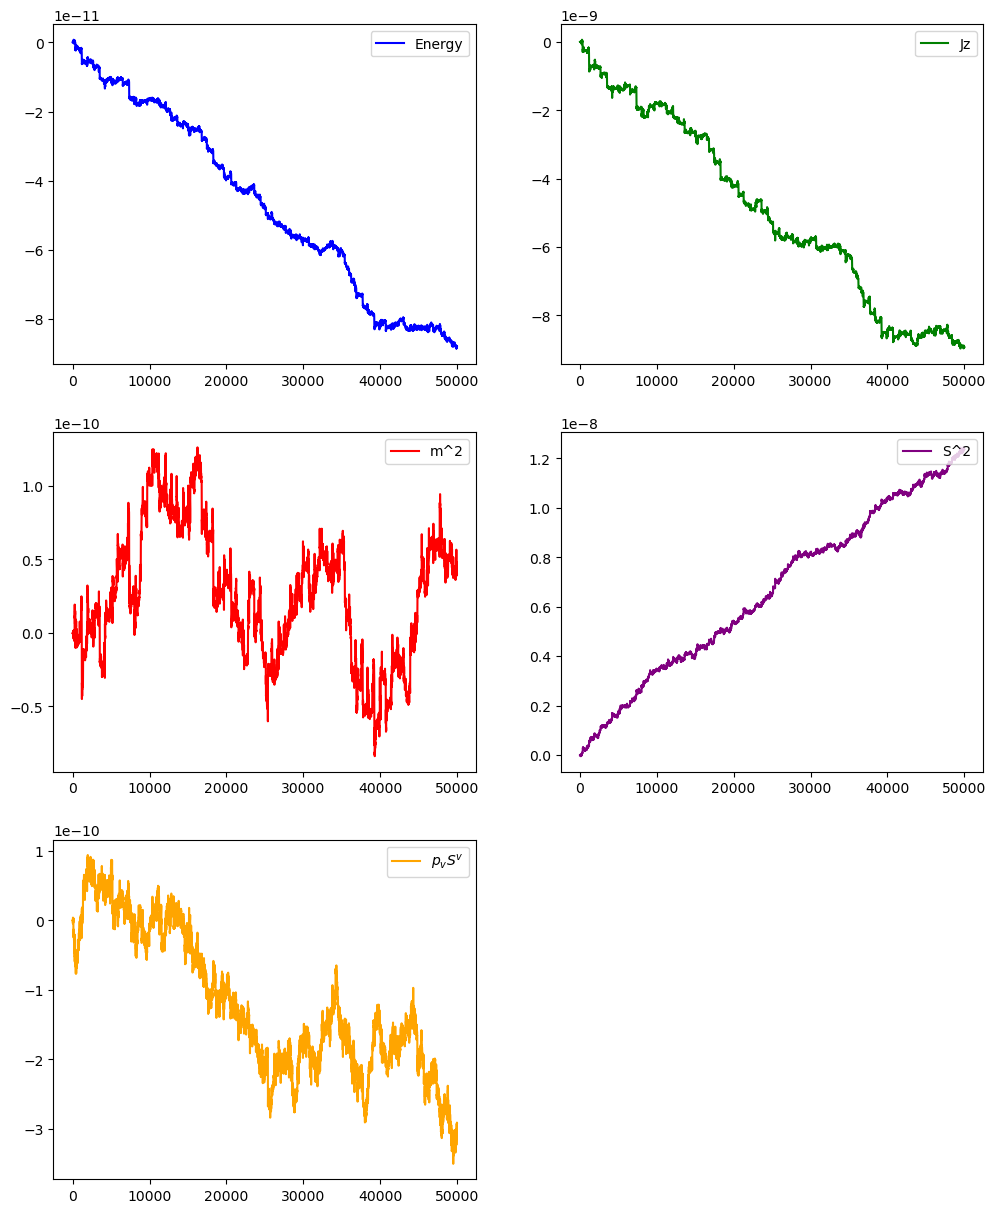

In [190]:
f, ax = plt.subplots(3, 2, figsize=(12, 15))
ax[0, 0].plot(sol.t, motconst[:, 0], label="Energy", color="blue")
ax[0, 1].plot(sol.t, motconst[:, 1], label="Jz", color="green")
ax[1, 0].plot(sol.t, motconst[:, 2], label="m^2", color="red")
ax[1, 1].plot(sol.t, motconst[:, 3], label="S^2", color="purple")
ax[2, 0].plot(sol.t, motconst[:, 4], label=r"$p_v S^v$", color="orange")
ax[0, 0].legend(loc="upper right")
ax[0, 1].legend(loc="upper right")
ax[1, 0].legend(loc="upper right")
ax[1, 1].legend(loc="upper right")
ax[2, 0].legend(loc="upper right")
f.delaxes(ax[2, 1])

In [191]:
# # Create subplots
# fig = make_subplots(
#     rows=3,
#     cols=2,
#     subplot_titles=(
#         "Energy Difference over Time",
#         "Angular Momentum Difference over Time",
#         "Mass Difference over Time",
#         "Spin Difference over Time",
#         "Constraint Difference over Time",
#     ),
# )

# # Add traces for each constant of motion
# fig.add_trace(
#     go.Scatter(
#         x=sol.t, y=motconst[:, 0], mode="lines", name="Energy", line=dict(color="blue")
#     ),
#     row=1,
#     col=1,
# )
# fig.add_trace(
#     go.Scatter(
#         x=sol.t, y=motconst[:, 1], mode="lines", name="Jz", line=dict(color="green")
#     ),
#     row=1,
#     col=2,
# )
# fig.add_trace(
#     go.Scatter(x=sol.t, y=motconst[:, 2], mode="lines", name="m^2", line=dict(color="red")),
#     row=2,
#     col=1,
# )
# fig.add_trace(
#     go.Scatter(
#         x=sol.t, y=motconst[:, 3], mode="lines", name="S^2", line=dict(color="purple")
#     ),
#     row=2,
#     col=2,
# )
# fig.add_trace(
#     go.Scatter(
#         x=sol.t,
#         y=motconst[:, 4],
#         mode="lines",
#         name=r"$p_v S^v$",
#         line=dict(color="orange"),
#     ),
#     row=3,
#     col=1,
# )

# # Update layout
# fig.update_layout(
#     title="Constant of Motion Differences over Time",
#     xaxis_title="Time",
#     yaxis_title="Difference",
#     width=1000,
#     height=800,
#     template="plotly_white",
# )

# # Show the plot
# fig.show()
# # sav

In [192]:
crsol = to_cartesian(rsol=rsol)

In [193]:
crsol

array([[ 6.00000000e+00,  0.00000000e+00,  3.67394040e-16],
       [ 5.98586505e+00,  5.32926354e-01, -1.43612858e-01],
       [ 5.92390426e+00,  1.06116266e+00, -2.86532921e-01],
       ...,
       [ 6.61875038e+00, -3.07999310e+00, -2.34911465e-01],
       [ 6.79263166e+00, -2.74280575e+00, -4.67384022e-01],
       [ 6.94028185e+00, -2.39631949e+00, -6.98845157e-01]])

In [194]:
# fig = go.Figure(
#     data=go.Scatter3d(
#         x=crsol[::2, 0],
#         y=crsol[::2, 1],
#         z=crsol[::2, 2],
#         marker=dict(
#             size=4,
#             color=crsol[::2, 2],
#             colorscale="Viridis",
#         ),
#         line=dict(color="darkblue", width=2),
#     )
# )

# fig.update_layout(
#     title=f"Particle motion with the initial conditions E={E:.3E}, Jz={Jz:.3E} and S={S:.3E}",
#     width=800,
#     height=700,
#     autosize=False,
#     scene=dict(
#         camera=dict(
#             up=dict(x=0, y=0, z=1),
#             eye=dict(
#                 x=0,
#                 y=1.0707,
#                 z=1,
#             ),
#         ),
#         aspectratio=dict(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     ),
# )

# # fig.update_traces(line_colorbar_exponentformat="E", selector=dict(type='parcoords'))

# fig.show()

In [195]:
poi_points = sol.y_events[0]

In [196]:
poi_points.shape

(450, 12)

In [197]:
# (abs(poi_points[:,2]-np.pi/2)).max()

In [198]:
# fig.write_html("chaoticfig.html")

In [199]:
# Poicare Plot

In [200]:
# fig = go.Figure(
#     data=go.Scatter(
#         x=poi_points[:, 1],
#         y=poi_points[:, 5],
#         mode="markers",
#         marker_color="rgba(0, 0, 0, 1)",
#         marker_size=1,
#     )
# )
# fig.update_layout(
#     autosize=False,
#     wi12
# width=500,
#     height=500,
#     margin=go.layout.Margin(
#         l=10.2,  # left margin
#         r=10.2,  # right margin
#         b=10.2,  # bottom margin
#         t=10.2,  # top margin
#     ),
# )

# fig.show()

In [201]:
vr = np.zeros(poi_points[:, 5].shape[0])

In [202]:
vr = np.zeros(poi_points[:, 5].shape[0])
for i in range(len(vr)):
    gkp = cov_metric_tensor(poi_points[i, 1], poi_points[i, 2], a0, M)
    levip = levi_civita_tensor(gkp)
    Stensorp = spintensor(levip, poi_points[i][4:8], poi_points[i][8:], gkp, m)
    rllllp = kerr_riemann_tensor(poi_points[i][1], poi_points[i][2], a0, M, "llll")
    vr[i] = rhs27(
        umu=poi_points[i, 4:8] / m,
        Stensor=Stensorp,
        rllll=rllllp,
        m=m,
    )[1]

In [203]:
# # Create a scatter plot
# fig = go.Figure(
#     data=go.Scatter(
#         x=poi_points[:, 1],
#         y=vr[:, 1],
#         mode="markers",
#         marker=dict(size=0.2, color="black"),
#     )
# )

# # Update layout
# fig.update_layout(
#     title=r"Poincare plot in $\theta = \pi/2$ plane",
#     xaxis_title="r",
#     yaxis_title=r"$V_r$",
# )

# # Show the plot
# fig.show()

Text(0, 0.5, '$V_r$')

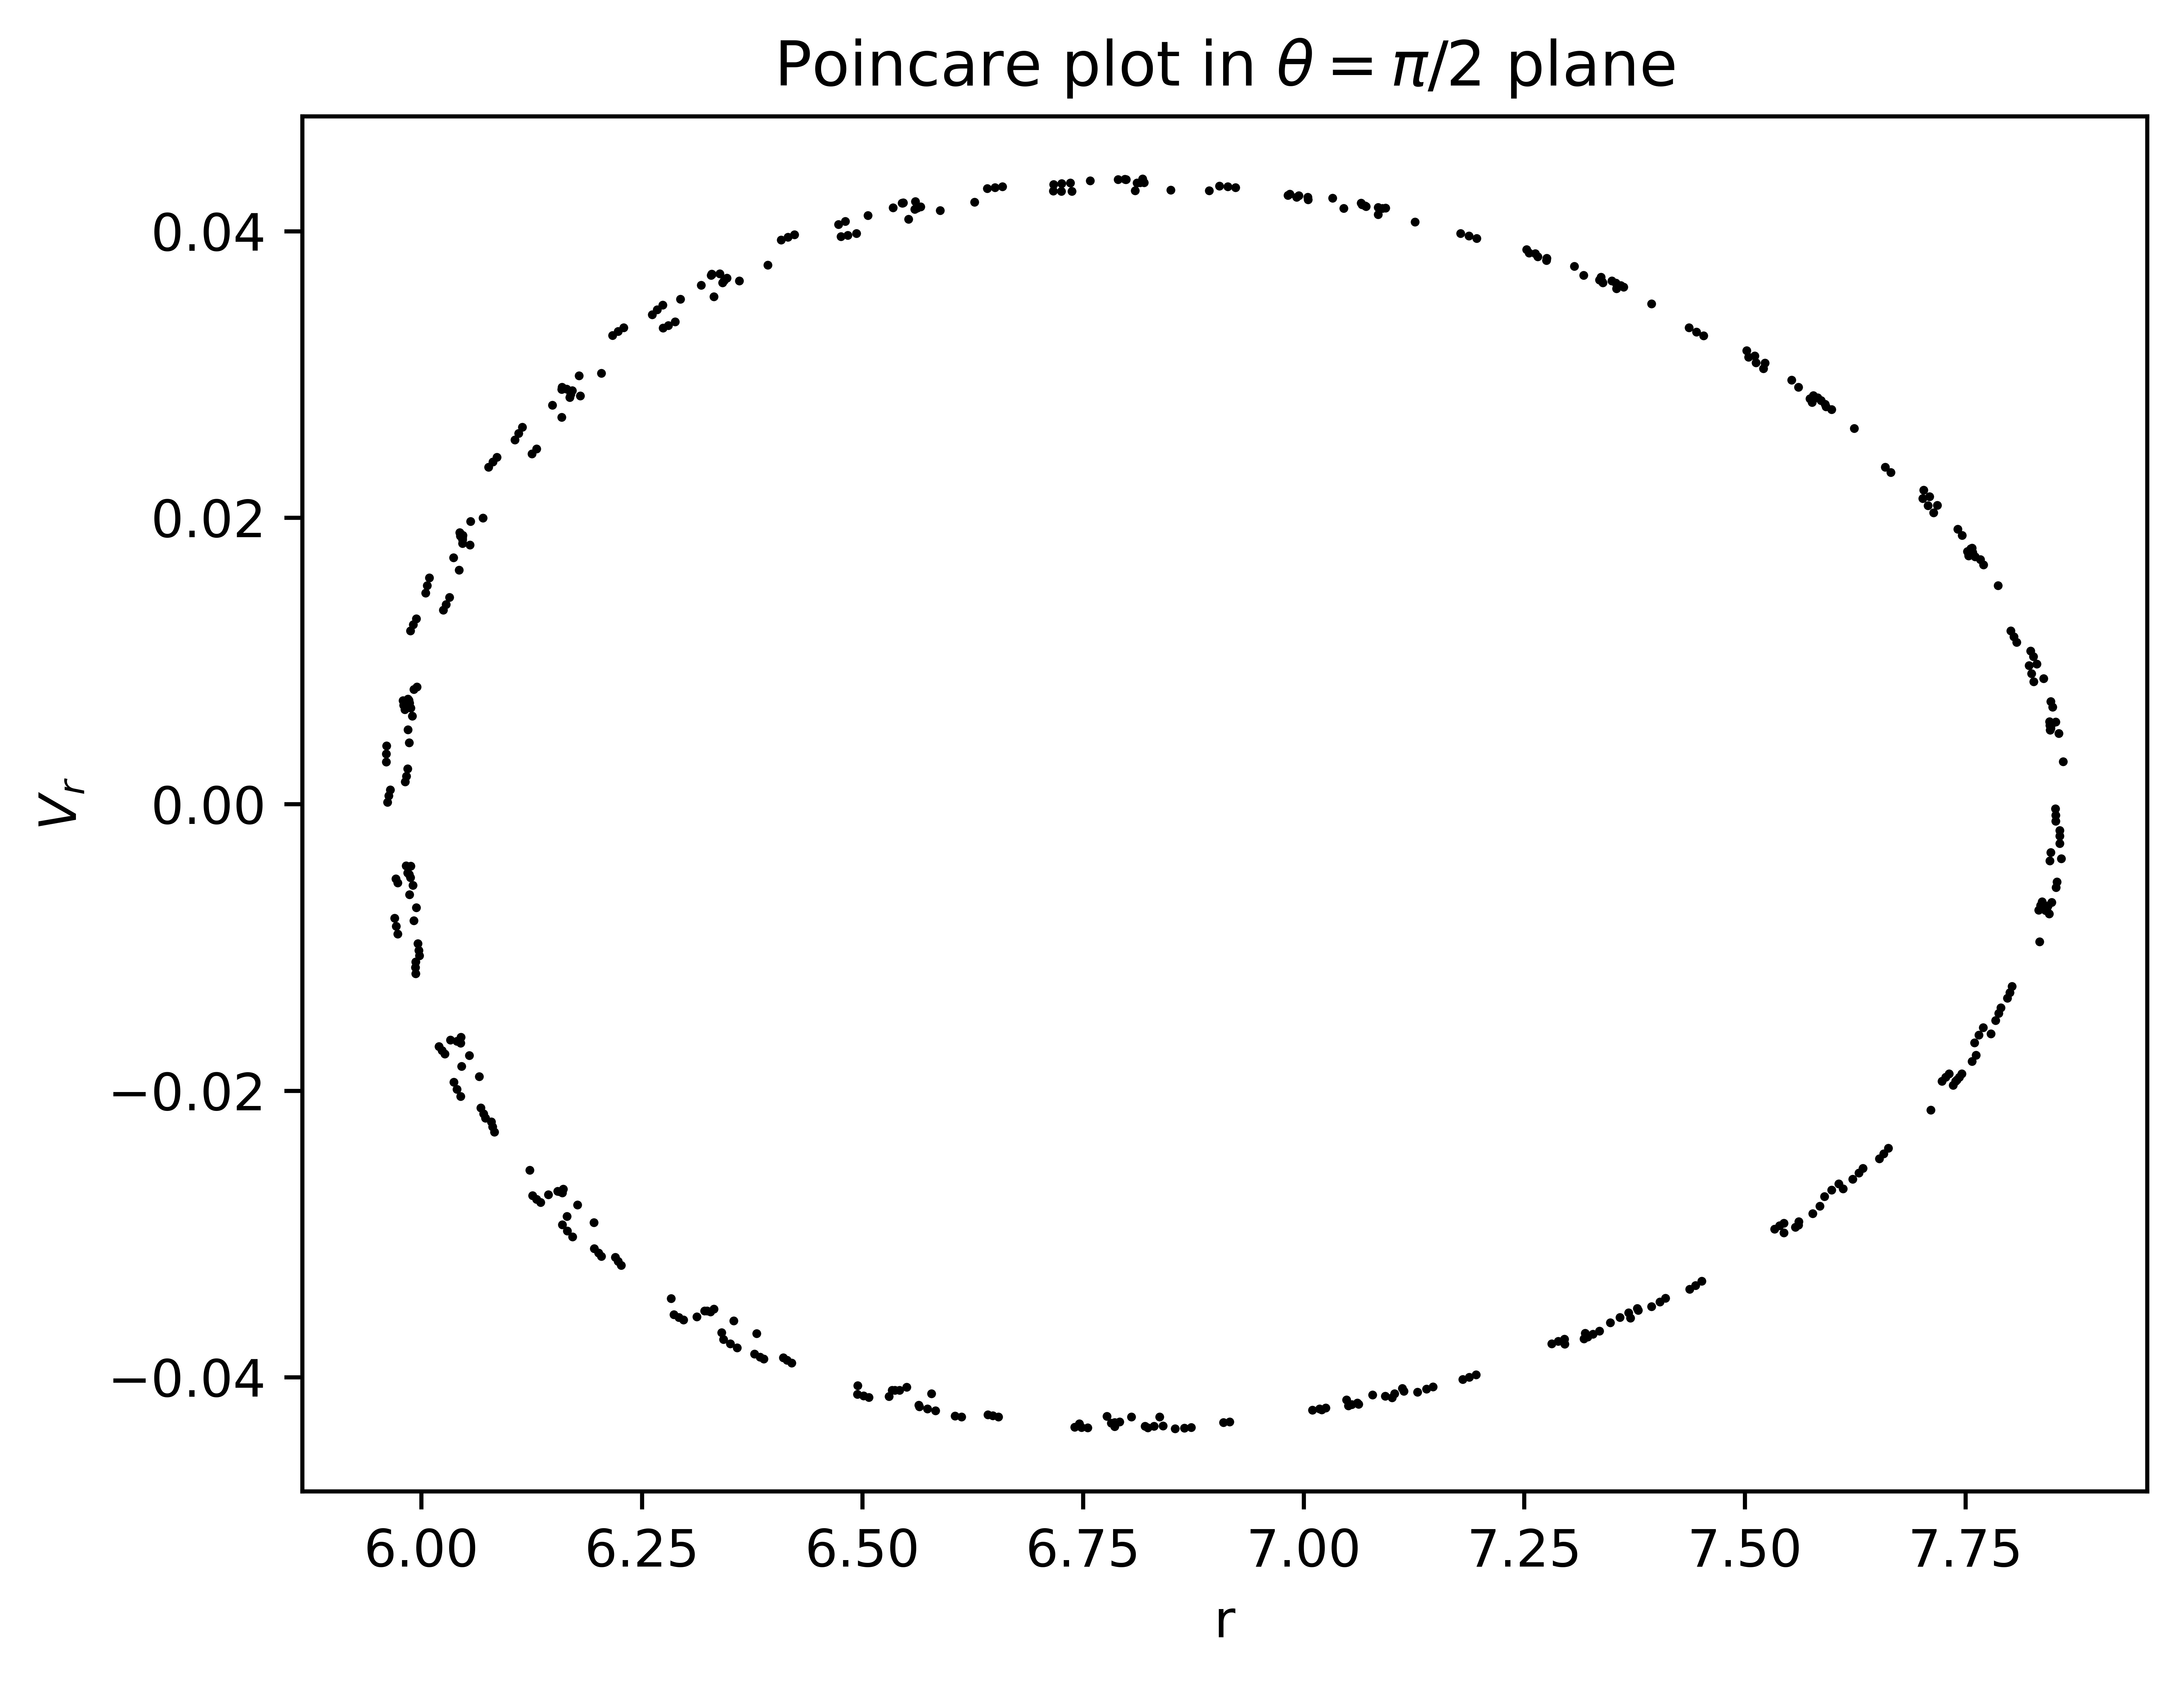

In [204]:
plt.figure(dpi=1200)
plt.scatter(poi_points[:, 1], vr, s=0.5, c="black")
plt.title(r"Poincare plot in $\theta = \pi/2$ plane")
plt.xlabel("r")
plt.ylabel(r"$V_r$")
# plt.savefig("Poincareplot_python.png")
# plt.xlim(9,10)
# plt.ylim(-4,-3)

In [205]:
max(rsol[:,1])

7.863683736677428

In [206]:
100.*7.25**(3/2)*2*np.pi/np.sqrt(M+m)

8673.050604785933

In [207]:
hull=ConvexHull(crsol)

In [208]:
len(hull.vertices)

2590

In [209]:
hullpoints= crsol[hull.vertices,:]

In [210]:
hdist= pdist(hullpoints,'euclidean')

In [211]:
hdist.max()

15.724780159680261

In [212]:
def Correlation_dimension(data, r=0.01):
    new_t = KDTree(data)

    sum = len(new_t.query_pairs(r, output_type="ndarray"))
    Corr_dimension = sum / len(data) ** 2

    return Corr_dimension

In [213]:
r = np.arange(0.0001, 1, 0.01)

In [214]:
cd001 = []
for i in range(len(r)):
    cd001.append(Correlation_dimension(crsol, r[i]))

In [215]:
intcept ,Codim= (
    np.polynomial.polynomial.Polynomial.fit(np.log10(r[8:]), np.log10(cd001[8:]), 1)
    .convert()
    .coef
)

In [216]:
Codim

2.8163361967466303

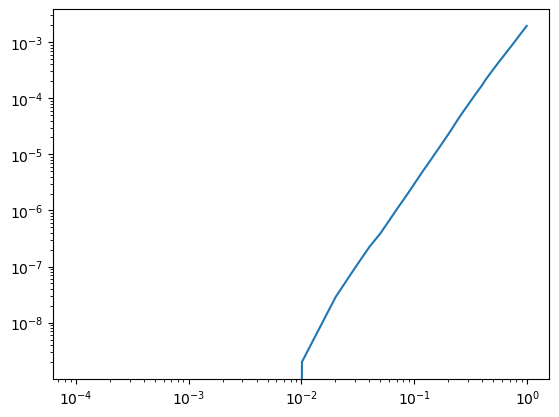

In [217]:
plt.loglog(r,cd001)
# plt.loglog(r,Codim*r+intcept)

In [218]:
# stop

## Create a Deviation Vector satisfying Constrains

In [300]:
dp0,dp3,ds0= smp.symbols("dp0 dp3 ds0",positive=True)
# ds0=0.0

In [301]:
rany0= np.random.uniform(0.,1.,(12,),).astype(object)*1e-7
rany0[[0, 4, 7, 8]] = [0.0, dp0, dp3, ds0]

In [302]:
# rany0[[9,10,11]]=0.0

In [303]:
rany0

array([0.0, 8.781174363909454e-08, 2.7387593197926163e-09,
       6.704675101784022e-08, dp0, 5.5868982844575165e-08,
       1.4038693859523377e-08, dp3, ds0, 9.682615757193975e-08,
       3.134241781592428e-08, 6.923226156693141e-08], dtype=object)

In [304]:
ry0 = y0 + rany0

In [305]:
eqC1=get_norm(ry0[4:8],gk)+m**2

In [306]:
eqC2= get_norm(ry0[8:],gk)-S**2

In [307]:
eqC3= np.einsum("ij,j,i->",gk,ry0[4:8],ry0[8:])

In [308]:
eqC1.expand()

-0.666666666666667*dp0**2 - 0.666666666666667*dp0*dp3 - 1.87385100780282*dp0 + 37.3333333333333*dp3**2 + 5.73284374904853*dp3 + 2.54501362206838e-8

In [309]:
eqC2.expand()

-0.666666666666667*ds0**2 - 0.880468171612004*ds0 + 9.3283936966615e-7

In [310]:
eqC3.expand()

-0.666666666666667*dp0*ds0 - 0.440234085806002*dp0 - 0.333333333333333*dp3*ds0 + 6.7370106194054*dp3 - 0.936925503901408*ds0 + 2.26457278595937e-7

In [311]:
Croots=smp.solve([eqC1,eqC2,eqC3],[dp0,dp3,ds0])
# Croots = smp.solve([eqC1, eqC3], [dp0, dp3])
display(Croots)

[(4.51860121665318e-7, 1.43256619691368e-7, 1.05948023046835e-6)]

In [313]:
ndp0,ndp3,nds0= Croots[0]

In [314]:
rany0[[4, 7, 8]] = [ndp0, ndp3, nds0]

In [315]:
rany0

array([0.0, 8.781174363909454e-08, 2.7387593197926163e-09,
       6.704675101784022e-08, 4.51860121665318e-7, 5.5868982844575165e-08,
       1.4038693859523377e-08, 1.43256619691368e-7, 1.05948023046835e-6,
       9.682615757193975e-08, 3.134241781592428e-08,
       6.923226156693141e-08], dtype=object)

In [316]:
ry0= (y0+rany0).astype(float)

In [317]:
ry0

array([0.00000000e+00, 6.00000009e+00, 1.57079633e+00, 6.70467510e-08,
       1.36092358e+00, 1.00000559e-02, 2.35867063e-02, 8.89304000e-02,
       5.67590486e-01, 1.09682616e-06, 1.03134242e-06, 1.85523404e-01])

In [318]:
dy0=ry0-y0
display(dy0)

array([0.00000000e+00, 8.78117437e-08, 2.73875922e-09, 6.70467510e-08,
       4.51860122e-07, 5.58689828e-08, 1.40386939e-08, 1.43256620e-07,
       1.05948023e-06, 9.68261576e-08, 3.13424178e-08, 6.92322616e-08])

In [319]:
np.linalg.norm(dy0)

1.1738318633921307e-06

In [237]:
dy0.tolist()

[0.0,
 6.726862267214528e-08,
 3.344414944983498e-08,
 6.629097973737623e-08,
 6.998750565756495e-07,
 2.859329350721196e-08,
 7.982668148373562e-08,
 2.049718698660108e-07,
 1.4649211836914589e-06,
 5.821046019213732e-08,
 2.8854682268053093e-08,
 9.572612225117183e-08]

# Numerically Compute Jacobian

In [ ]:
def fjac(t, x, p):
    x = x.astype(np.complex128)
    # fx = mpd(0, x, p)
    n = 12
    J = np.zeros((n, n))

    for i in range(n):
        J[:, i] = mpd(0, x + H[i], p).imag / H[i, i].imag

    return J.T

In [ ]:
def solve_combined(t,y,p):
    mpdarr= mpd(t,y[:12],p)
    jac= fjac(t,y[:12],p)

    dY= y[12:]

    dY_dt= np.einsum("ij,j->i",jac,dY)

    dydtf= dY_dt.flatten()

    du_= np.zeros((24,))

    du_[:12]= mpdarr
    du_[12:]= dydtf

    return du_


In [ ]:
w0= dy0
w0= w0/np.linalg.norm(w0)

In [ ]:
w0

In [ ]:
ics0= np.array((y0,w0)).flatten()

In [ ]:
(
    solve_combined(0.0, ics0, p))

In [ ]:
tau = 100*M  # Renormalization time
tf = 10000.0  # Final time
steps= 100

In [ ]:
# @nb.njit
def evolve_lyap(ics0, tau, tf, steps,p):

    ti = 0.0  # * Initial Time
    timestep = np.arange(ti, tf+tau, tau)  # * Time interval
    size = timestep.shape[0]

    X1t = np.zeros((size - 1))  # *Lyapunaov Exponents
    sum = 0.0
    ics = ics0.copy()  # *We do not want to change our initial conditions
    # h = np.zeros(size - 1)  # *Check for energy
    # sol = np.zeros((size, 12))
    # sol[0, :] = ics[:12]
    # traj=np.zeros((steps,6),dtype=np.float64)

    for i in range(0, size - 1):
        timeint = np.linspace(
            timestep[i], timestep[i + 1], steps
        )  #!Our time interval with 10000 points between them

        # Uncomment following line to use scipy solver and comment above two lines
        usol=solve_ivp(solve_combined,[timeint[0],timeint[-1]],ics,'LSODA',t_eval=timeint,args=(p,),atol=1e-12,rtol=1e-12).y[:,-1]

        xk = usol[:12]  # Orbit at t= tau
        wk = usol[12:]  # Deviations at t=tau

        # *---------------------The following algorithm is from the paper

        alphak = np.linalg.norm(wk)
        sum = sum + np.log(alphak)
        X1t[i] = sum / timestep[i + 1]
        wk0 = wk / alphak

        # *----------------------Lyapunaov Exponents calculated above
        #! Now for another time step. Set the current solution as the initial conditions for next time steps
        ics[:12] = xk
        ics[12:] = wk0

        #! ------------------------Sanity Check--------------------------
        # if sanity_check!=0:
        # h[i] = H(1.00, ics, alpha)  #! Current Energy
        # sol[i + 1, :] = ics[:12]
        #! Comment above line if you do not want to perform the sanity check

    # if sanity_check!=0:
    #     return X1t,h,sol, traj

    return X1t  #, h, sol

In [ ]:
lyaps=evolve_lyap(ics0,tau,tf,steps,p)

In [ ]:
np.average(lyaps[20:])

In [ ]:
1/(18*M) #Theoretical

In [ ]:
plt.plot(np.arange(0., tf, tau),lyaps)

# Constraint Deviation Vectors

In [270]:
dp0, dp3, ds0 = smp.symbols("dp0 dp3 ds0",positive=True)

In [271]:
EPS = 1e-10

In [272]:
np.random.seed(1)
dy0 = np.random.uniform(0.0, 1.0, y0.shape).astype(object) * EPS
dy0[[0, 4, 7, 8]] = 0, dp0, dp3, ds0

In [273]:
dy0

array([0, 7.203244934421581e-11, 1.1437481734488665e-14,
       3.023325726318398e-11, dp0, 9.23385947687978e-12,
       1.862602113776709e-11, dp3, ds0, 5.3881673400335695e-11,
       4.1919451440329484e-11, 6.852195003967595e-11], dtype=object)

In [274]:
ry0 = y0 + dy0

In [275]:
ry0

array([0.0, 6.000000000072032, 1.570796326794908, 3.023325726318398e-11,
       dp0 + 1.36092312749911, 0.01000000000923386, 0.02358669228475408,
       dp3 + 0.0889302567059991, ds0 + 0.567589426544891,
       1.0000538816734004e-06, 1.0000419194514403e-06,
       0.18552333516448447], dtype=object)

In [276]:
eqC1 = get_norm(ry0[4:8], gk) + m**2

In [277]:
pyperclip.copy(smp.mathematica_code(eqC1.simplify()))

In [278]:
eqC2 = get_norm(ry0[8:], gk) - S**2

In [279]:
pyperclip.copy(smp.mathematica_code(eqC2.simplify()))

In [280]:
eqC3 = np.einsum("ij,j,i->", gk, ry0[4:8], ry0[8:])

In [281]:
pyperclip.copy(smp.mathematica_code(eqC3.simplify()))

In [282]:
const_roots=smp.solve([eqC1,eqC2,eqC3],[dp0,dp3,ds0])

In [283]:
y0

array([0.00000000e+00, 6.00000000e+00, 1.57079633e+00, 0.00000000e+00,
       1.36092313e+00, 1.00000000e-02, 2.35866923e-02, 8.89302567e-02,
       5.67589427e-01, 1.00000000e-06, 1.00000000e-06, 1.85523335e-01])

In [284]:
const_roots

[(4.46791380345552e-10, 1.40474736595005e-10, 1.04861230553702e-9)]

In [285]:
# def const_jac_nl_symb():
#     X = smp.Matrix([eqC1, eqC2, eqC3])
#     Y = smp.Matrix([dp0, dp2, ds0])
#     return X.jacobian(Y)

In [286]:
# const_jac = const_jac_nl_symb()

In [287]:
# def const_jac_nl(p_0, p_2, s_0):
#     f = smp.lambdify([dp0, dp2, ds0], const_jac)

#     return f(p_0, p_2, s_0)

In [288]:
# def const_solve_eq(p_0, p_2, s_0):
#     f = smp.lambdify([dp0, dp2, ds0], [eqC1, eqC2, eqC3])

#     return f(p_0, p_2, s_0)

In [289]:
# const_roots = mpmath.findroot(
#     const_solve_eq,
#     (EPS, EPS, EPS),
#     solver="mdnewton",
#     tol=1e-24,
#     J=const_jac_nl,
#     verify=True,
# )

In [290]:
const_roots = np.array(const_roots[0], dtype=np.float64)

In [291]:
const_roots

array([4.46791380e-10, 1.40474737e-10, 1.04861231e-09])

In [292]:
# const_solve_eq(*const_roots)

In [293]:
ndp0, ndp3, nds0 = const_roots

In [294]:
# ry0[[4,6,8]]=dp0,dp2,ds0
dy0[[4, 7, 8]] = ndp0, ndp3, nds0

In [295]:
np.linalg.norm(dy0)

1.1553502091700337e-09

In [296]:
ry0 = (dy0 + y0).astype(float)

In [297]:
ry0

array([0.00000000e+00, 6.00000000e+00, 1.57079633e+00, 3.02332573e-11,
       1.36092313e+00, 1.00000000e-02, 2.35866923e-02, 8.89302568e-02,
       5.67589428e-01, 1.00005388e-06, 1.00004192e-06, 1.85523335e-01])

In [299]:
tau = 100*M
tf = 20000

In [ ]:
# @snoop
def evolve_lyap2(y0, y1,p):
    ti = 0.0
    timestep = np.arange(ti, tf+tau, tau)
    li = np.zeros(len(timestep) - 1)
    dsoly0 = np.zeros((len(timestep), 12))
    dsoly1 = np.zeros((len(timestep), 12))
    dsoly0[0,:]=y0
    dsoly1[0,:]=y1

    for i in range(len(timestep) - 1):
        soly0 = solve_ivp(
            fun=mpd,
            t_span=[timestep[i], timestep[i + 1]],
            y0=y0,
            method="LSODA",
            t_eval=np.arange(timestep[i], timestep[i + 1], 1.0),
            args=(p,),
            rtol=1e-12,
            atol=1e-12,
        ).y[:, -1]

        soly1 = solve_ivp(
            fun=mpd,
            t_span=[timestep[i], timestep[i + 1]],
            y0=y1,
            method="LSODA",
            t_eval=np.arange(timestep[i], timestep[i + 1], 1.0),
            args=(p,),
            rtol=1e-12,
            atol=1e-12,
        ).y[:, -1]

        # v1 = (soly1 - soly0) / np.linalg.norm(soly1 - soly0)
        li[i]= np.log(np.linalg.norm(soly1-soly0)/np.linalg.norm(y1-y0))/tau

        # li[i] = np.log(np.linalg.norm(soly1 - soly0) / EPS) / tau

        y0 = soly0
        y1= soly1
        # y1 = y0 + EPS * v1

        # dsoly0[i+1,:]=y0
        # dsoly1[i+1,:]=y1
        # print(i)

    return li#, dsoly0,dsoly1

In [ ]:
lis = evolve_lyap2(y0, ry0, p)

In [ ]:
len(lis)

In [ ]:
np.average(lis[100:])

In [ ]:
plt.plot(lis[100:])

In [ ]:
lis[1]

In [ ]:
# i = -1
# gki = cov_metric_tensor(lis[1][i][1], lis[1][i][2], a0, M)
# get_constants(rsol=lis[1][i], gk=gki, a=a0,m=m, M=M)[0] - E, get_constants(
#     rsol=lis[1][i], gk=gki, a=a0,m=m, M=M
# )[1] - Jz, get_constants(rsol=lis[1][i], gk=gki, a=a0,m=m, M=M)[2] + m**2, get_constants(
#     rsol=lis[1][i], gk=gki, a=a0,m=m, M=M
# )[
#     3
# ] - S**2

In [ ]:
# i = -1
# gki = cov_metric_tensor(lis[2][i][1], lis[2][i][2], a0, M)
# get_constants(rsol=lis[2][i], gk=gki, a=a0,m=m, M=M)[0] - E, get_constants(
#     rsol=lis[2][i], gk=gki, a=a0,m=m, M=M
# )[1] - Jz, get_constants(rsol=lis[2][i], gk=gki, a=a0,m=m, M=M)[2] + m**2, get_constants(
#     rsol=lis[2][i], gk=gki, a=a0,m=m, M=M
# )[
#     3
# ] - S**2

In [ ]:
# motconst = np.array(
#     [
#         get_constants(lis[1][i], cov_metric_tensor(lis[1][i][1], lis[1][i][2], a0, M), a0,m, M)
#         - np.array([E, Jz, -m**2, S**2, 0.0])
#         for i in range(len(lis[1]))
#     ]
# )

In [ ]:
# f, ax = plt.subplots(3, 2, figsize=(12, 15))
# ax[0, 0].plot( motconst[:, 0], label="Energy", color="blue")
# ax[0, 1].plot( motconst[:, 1], label="Jz", color="green")
# ax[1, 0].plot( motconst[:, 2], label="m^2", color="red")
# ax[1, 1].plot( motconst[:, 3], label="S^2", color="purple")
# ax[2, 0].plot( motconst[:, 4], label=r"$p_v S^v$", color="orange")
# ax[0, 0].legend(loc="upper right")
# ax[0, 1].legend(loc="upper right")
# ax[1, 0].legend(loc="upper right")
# ax[1, 1].legend(loc="upper right")
# ax[2, 0].legend(loc="upper right")
# f.delaxes(ax[2, 1])

In [ ]:
# i=0
# gki = cov_metric_tensor(lis[2][i][1], lis[2][i][2], a0, M)
# newE, newJz, newm, newSm, newPS = get_constants(rsol=lis[2][i], gk=gki, a=a0,m=m, M=M)

In [ ]:
# newE,newJz,newm,newSm,newPS

In [ ]:
# i = -1
# gki = cov_metric_tensor(lis[2][i][1], lis[2][i][2], a0, M)
# get_constants(rsol=lis[2][i], gk=gki, a=a0,m=m, M=M)[0] - newE, get_constants(
#     rsol=lis[2][i], gk=gki, a=a0,m=m, M=M
# )[1] - newJz, get_constants(rsol=lis[2][i], gk=gki, a=a0,m=m, M=M)[2] - newm, get_constants(
#     rsol=lis[2][i], gk=gki, a=a0,m=m, M=M
# )[
#     3
# ] - newSm

In [ ]:
# motconst = np.array(
#     [
#         get_constants(
#             rsol=lis[2][i],
#             gk=cov_metric_tensor(lis[2][i][1], lis[2][i][2], a0, M),
#             a=a0,
#             m=m,
#             M=M,
#         )
#         - np.array([newE, newJz, newm, newSm, newPS])
#         for i in range(len(lis[2]))
#     ]
# )

In [ ]:
# f, ax = plt.subplots(3, 2, figsize=(12, 15))
# ax[0, 0].plot(motconst[:, 0], label="Energy", color="blue")
# ax[0, 1].plot(motconst[:, 1], label="Jz", color="green")
# ax[1, 0].plot(motconst[:, 2], label="m^2", color="red")
# ax[1, 1].plot(motconst[:, 3], label="S^2", color="purple")
# ax[2, 0].plot(motconst[:, 4], label=r"$p_v S^v$", color="orange")
# ax[0, 0].legend(loc="upper right")
# ax[0, 1].legend(loc="upper right")
# ax[1, 0].legend(loc="upper right")
# ax[1, 1].legend(loc="upper right")
# ax[2, 0].legend(loc="upper right")
# f.delaxes(ax[2, 1])

In [ ]:
# cdsoly0=to_cartesian(lis[1])
# cdsoly1 = to_cartesian(lis[2])

In [ ]:
# dcdsol= cdsoly1-cdsoly0

In [ ]:
# fig = go.Figure(
#     data=go.Scatter3d(
#         x=cdsoly0[::2, 0],
#         y=cdsoly0[::2, 1],
#         z=cdsoly0[::2, 2],
#         marker=dict(
#             size=4,
#             color=cdsoly0[::2, 2],
#             colorscale="Viridis",
#         ),
#         line=dict(color="darkblue", width=2),
#     )
# )

# fig.update_layout(
#     title=f"Particle motion with the initial conditions E={E:.3E}, Jz={Jz:.3E} and S={S:.3E}",
#     width=800,
#     height=700,
#     autosize=False,
#     scene=dict(
#         camera=dict(
#             up=dict(x=0, y=0, z=1),
#             eye=dict(
#                 x=0,
#                 y=1.0707,
#                 z=1,
#             ),
#         ),
#         aspectratio=dict(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     ),
# )

# # fig.update_traces(line_colorbar_exponentformat="E", selector=dict(type='parcoords'))

# fig.show()

# Lyapunov Exponent using arxiv:gr-qc/0302118

In [240]:
# @snoop
def mpdCT(t, y, p):
    """
    Solve the MPD Equations Given the Initial Conditions
    """
    a, m, M = p
    # if:
    #     dy = np.zeros_like(y, dtype=np.complex128)
    # else:
    #     dy=np.zeros_like(y,dtype=np.float64)
    dy = np.zeros_like(y, dtype=type(y[0]))
    ps = y[4:8]
    su = y[8:]

    gk = cov_metric_tensor(r=y[1], theta=y[2], a=a, M=M)
    cs = kerr_christoffel(r=y[1], theta=y[2], a=a, M=M)  #! G^i_{jk}

    levi = levi_civita_tensor(gk)
    levi_mixed = np.einsum("psab,au,bv->psuv", levi, gk, gk)

    rulll = kerr_riemann_tensor(y[1], y[2], a, M, "ulll")
    rllll = np.einsum("ij,jvps->ivps", gk, rulll)

    Stensor = spintensor(levi, ps, su, gk, m)

    vmu = rhs27(umu=ps / m, Stensor=Stensor, rllll=rllll, m=m)
    # norm= vmu[0]

    # vmu=vmu/norm

    dp = rhs23(vmu=vmu, su=su, ps=ps, cs=cs, rulll=rulll, epsilon_mixed=levi_mixed, m=m)
    # dp= dp/norm

    ds = rhs24(vmu=vmu, su=su, ps=ps, cs=cs, rllll=rllll, epsilon_mixed=levi_mixed, m=m)
    # ds= ds/norm

    dy[:4] = vmu / vmu[0]
    dy[4:8] = dp / vmu[0]
    dy[8:] = ds / vmu[0]

    return dy

In [243]:
solCTy0 = solve_ivp(
    fun=mpdCT,
    t_span=[0.0, 20000.0],
    y0=y0,
    method="LSODA",
    t_eval=np.arange(0.0, 20000.0, 1),
    args=(p,),
    rtol=1e-13,
    atol=1e-13,
)

In [265]:
solCTy0__ = solve_ivp(
    fun=mpd,
    t_span=[0.0, 20000.0],
    y0=y0,
    method="LSODA",
    t_eval=np.arange(0.0, 20000.0, 1),
    args=(p,),
    rtol=1e-13,
    atol=1e-13,
)

In [244]:
solCTy1 = solve_ivp(
    fun=mpdCT,
    t_span=[0.0, 20000.0],
    y0=ry0,
    method="LSODA",
    t_eval=np.arange(0.0, 20000.0, 1),
    args=(p,),
    rtol=1e-13,
    atol=1e-13,
)

In [246]:
csolCTy0,csolCTy1= solCTy0.y.T,solCTy1.y.T

In [247]:
vr = np.zeros((csolCTy0[:, 5].shape[0],4))
for i in range(len(vr)):
    gkp = cov_metric_tensor(csolCTy0[i, 1], csolCTy0[i, 2], a0, M)
    levip = levi_civita_tensor(gkp)
    Stensorp = spintensor(levip, csolCTy0[i][4:8], csolCTy0[i][8:], gkp, m)
    rllllp = kerr_riemann_tensor(csolCTy0[i][1], csolCTy0[i][2], a0, M, "llll")
    vr[i] = rhs27(
        umu=csolCTy0[i, 4:8] / m,
        Stensor=Stensorp,
        rllll=rllllp,
        m=m,
    )

In [254]:
dxa=csolCTy1[:,:4]-csolCTy0[:,:4]

In [261]:
gkp0 = cov_metric_tensor(csolCTy0[0, 1], csolCTy0[0, 2], a0, M)
hab0= gkp0 + np.einsum("i,j->ij",vr[0],vr[0])

In [262]:
gkpe = cov_metric_tensor(csolCTy0[-1, 1], csolCTy0[-1, 2], a0, M)
habe = gkpe + np.einsum("i,j->ij", vr[-1], vr[-1])

In [264]:
dxp0= np.einsum("ab,b->a",hab0,dxa[0])
dxpe = np.einsum("ab,b->a", habe, dxa[-1])

In [267]:
dL0= np.sqrt(np.einsum("ab,a,b->",hab0,dxa[0],dxa[0]))

In [268]:
dLe = np.sqrt(np.einsum("ab,a,b->", habe, dxa[-1], dxa[-1]))

In [269]:
1/20000. * np.log(dLe/dL0)

0.0006047353965290695

# Lyapunov Exponent using PhysRevD.55.4848

In [ ]:
tau = 100 * M
tf = 40000

In [ ]:
# # @snoop
# def evolve_lyap3(y0, y1, p):
#     ti = 0.0
#     timestep = np.arange(ti, tf + tau, tau)
#     # li = np.zeros(len(timestep) - 1)
#     # dsoly0 = np.zeros((len(timestep), 12))
#     # dsoly1 = np.zeros((len(timestep), 12))
#     # dsoly0[0, :] = y0
#     # dsoly1[0, :] = y1

#     dev0= np.zeros((len(timestep),2))
#     dev1 = np.zeros((len(timestep), 2))

#     dev0[0,:]=y0[[1,2]]
#     dev1[0, :] = y1[[1, 2]]

#     for i in range(len(timestep) - 1):
#         soly0 = solve_ivp(
#             fun=mpd,
#             t_span=[timestep[i], timestep[i + 1]],
#             y0=y0,
#             method="LSODA",
#             t_eval=np.arange(timestep[i], timestep[i + 1], 1.0),
#             args=(p,),
#             rtol=1e-12,
#             atol=1e-12,
#         ).y[:, -1]

#         soly1 = solve_ivp(
#             fun=mpd,
#             t_span=[timestep[i], timestep[i + 1]],
#             y0=y1,
#             method="LSODA",
#             t_eval=np.arange(timestep[i], timestep[i + 1], 1.0),
#             args=(p,),
#             rtol=1e-12,
#             atol=1e-12,
#         ).y[:, -1]

#         # v1 = (soly1 - soly0) / np.linalg.norm(soly1 - soly0)
#         # li[i] = np.log(np.linalg.norm(soly1 - soly0) / np.linalg.norm(y1 - y0)) / tau

#         # li[i] = np.log(np.linalg.norm(soly1 - soly0) / EPS) / tau

#         y0 = soly0
#         y1 = soly1

#         dev0[i+1, :] = y0[[1, 2]]
#         dev1[i+1, :] = y1[[1, 2]]
#     # y1 = y0 + EPS * v1

#     # dsoly0[i+1,:]=y0
#     # dsoly1[i+1,:]=y1
#     # print(i)

#     return dev0,dev1 # , dsoly0,dsoly1

In [ ]:
timestep=np.arange(0.0, tf + tau, tau)

In [ ]:
soly0 = solve_ivp(
            fun=mpd,
            t_span=[0.,tf],
            y0=y0,
            method="LSODA",
            t_eval=np.arange(0., tf, 1.0),
            args=(p,),
            rtol=1e-12,
            atol=1e-12,
        )

In [ ]:
rsoly0= soly0.y.T

In [ ]:
np.sin(rsoly0[:,2])

In [ ]:
timestep = np.arange(0.0, tf, 1.0)

In [ ]:
dev0 = np.zeros((len(timestep), 4))

In [ ]:
rho0 = rsoly0[:, 1] * np.sin(rsoly0[:, 2])
z0 = rsoly0[:, 1] * np.cos(rsoly0[:, 2])

In [ ]:
dev0[:,0]=rho0
dev0[:,1]=z0

In [ ]:
for i in range(len(rsoly0)):
    gkp0 = cov_metric_tensor(rsoly0[i, 1], rsoly0[i, 2], a0, M)
    # gkp1 = cov_metric_tensor(srsoly1[i, 1], srsoly1[i, 2], a0, M)

    levip0 = levi_civita_tensor(gkp0)
    # levip1 = levi_civita_tensor(gkp1)

    Stensorp0 = spintensor(levip0, rsoly0[i][4:8], rsoly0[i][8:], gkp0, m)
    # Stensorp1 = spintensor(levip1, srsoly1[i][4:8], srsoly1[i][8:], gkp1, m)

    rllllp0 = kerr_riemann_tensor(rsoly0[i][1], rsoly0[i][2], a0, M, "llll")
    # rllllp1 = kerr_riemann_tensor(srsoly1[i][1], srsoly1[i][2], a0, M, "llll")

    dev0[i,[[2,3]]] = rhs27(
        umu=rsoly0[i, 4:8] / m,
        Stensor=Stensorp0,
        rllll=rllllp0,
        m=m,
    )[[1,2]]

    # dev1[i,[[2,3]]]np.linalg.norm(dev0[-1]-dev0[-2]) = rhs27(
    #     umu=srsoly1[i, 4:8] / m,
    #     Stensor=Stensorp1,
    #     rllll=rllllp1,
    #     m=m,
    # )[[1,2]]

In [ ]:
np.linalg.norm(dev0[-1] - dev0[-2])

In [ ]:
# dev0,dev1= evolve_lyap3(y0,ry0,p)

In [ ]:
# !jupytext --output Einstenpy.py Einsteinpy.ipynb

In [10]:
def Skerr_riemann_tensor(r, theta, a,Delta,Sigma, M=1.0, config="ulll"):
    """
    Define variables

    Components of the Riemann tensor for Kerr Metric
    From Reference Paper, Appendix
    The Configuration is ulll
    """

    rijkl = np.zeros((4, 4, 4, 4), dtype=type(r))

    # Definitions
    # Delta = a**2 - 2.0 * M * r + r**2
    # Sigma = r**2 + a**2 * sme.cos(theta) ** 2


    rijkl[0, 0, 0, 3] = (
        2.0
        * M**2
        * sme.sin(theta) ** 2
        * a
        * r**2
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        / Sigma**4
    )

    rijkl[0, 0, 1, 2] = (
        -2.0
        * M**2
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * r
        * sme.cos(theta)
        * a**2
        * sme.sin(theta)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 0, 1] = (
        M
        * r
        * (2.0 * (r**2 + a**2) + a**2 * sme.sin(theta) ** 2)
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 0, 2] = (
        -M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2 * M * r)
        * a**2
        * sme.sin(theta)
        * sme.cos(theta)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 1, 3] = (
        3.0
        * M
        * sme.sin(theta) ** 2
        * a
        * r
        * (r**2 + a**2)
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 2, 3] = (
        -M
        * sme.cos(theta)
        * sme.sin(theta)
        * a
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (2.0 * (r**2 + a**2) ** 2 + a**2 * sme.sin(theta) ** 2 * Delta)
        / (Sigma**3 * Delta)
    )

    # Antisymmetric under exchange of last two indices.
    rijkl[0, 0, 3, 0] = -rijkl[0, 0, 0, 3]
    rijkl[0, 0, 2, 1] = -rijkl[0, 0, 1, 2]
    rijkl[0, 1, 1, 0] = -rijkl[0, 1, 0, 1]
    rijkl[0, 1, 2, 0] = -rijkl[0, 1, 0, 2]
    rijkl[0, 1, 3, 1] = -rijkl[0, 1, 1, 3]
    rijkl[0, 1, 3, 2] = -rijkl[0, 1, 2, 3]

    #! -------------------------------------------------------------------------------------#

    rijkl[0, 2, 0, 1] = (
        -M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4 * M * r)
        * a**2
        * sme.sin(theta)
        * sme.cos(theta)
        / (Sigma**3 * Delta)
    )
    rijkl[0, 2, 0, 2] = (
        -M
        * r
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (r**2 + a**2 + 2 * a**2 * sme.sin(theta) ** 2)
        / Sigma**3
    )
    rijkl[0, 2, 1, 3] = (
        -M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * ((a**2 + r**2) ** 2 + 2.0 * a**2 * sme.sin(theta) ** 2 * Delta)
        * a
        * sme.sin(theta)
        * sme.cos(theta)
        / (Sigma**3 * Delta)
    )
    rijkl[0, 2, 2, 3] = (
        -3.0
        * M
        * sme.sin(theta) ** 2
        * r
        * a
        * (a**2 + r**2)
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        / Sigma**3
    )
    rijkl[0, 3, 0, 3] = (
        -sme.sin(theta) ** 2
        * M
        * r
        * (r**2 + 3 * a**2 * sme.sin(theta) ** 2 - 3 * a**2)
        * ((a**2 + r**2) ** 2 - a**2 * sme.sin(theta) ** 2 * Delta)
        / Sigma**4
    )
    rijkl[0, 3, 1, 2] = (
        (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * M
        * ((a**2 + r**2) ** 2 - a**2 * sme.sin(theta) ** 2 * Delta)
        * a
        * sme.sin(theta)
        * sme.cos(theta)
        / (Sigma**3 * Delta)
    )

    # Symmetries
    rijkl[0, 2, 1, 0] = -rijkl[0, 2, 0, 1]
    rijkl[0, 2, 2, 0] = -rijkl[0, 2, 0, 2]
    rijkl[0, 2, 3, 1] = -rijkl[0, 2, 1, 3]
    rijkl[0, 2, 3, 2] = -rijkl[0, 2, 2, 3]
    rijkl[0, 3, 3, 0] = -rijkl[0, 3, 0, 3]
    rijkl[0, 3, 2, 1] = -rijkl[0, 3, 1, 2]

    #! ------------------------------------------------------------------------------#

    rijkl[1, 0, 0, 1] = (
        r
        * M
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (a**2 * sme.sin(theta) ** 2 + 2.0 * Delta)
        / Sigma**4
    )
    rijkl[1, 0, 0, 2] = (
        -3.0
        * M
        * Delta
        * a**2
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * sme.sin(theta)
        * sme.cos(theta)
        / Sigma**4
    )
    rijkl[1, 0, 1, 3] = (
        r
        * M
        * a
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * sme.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[1, 0, 2, 3] = (
        -a
        * M
        * (2.0 * (r**2 + a**2) + a**2 * sme.sin(theta) ** 2)
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * Delta
        * sme.cos(theta)
        * sme.sin(theta)
        / Sigma**4
    )
    rijkl[1, 2, 0, 3] = (
        -sme.cos(theta)
        * M
        * sme.sin(theta)
        * a
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * Delta
        / Sigma**3
    )
    rijkl[1, 2, 1, 2] = -M * r * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2) / Sigma**2
    rijkl[1, 3, 0, 1] = (
        -sme.sin(theta) ** 2
        * M
        * r
        * a
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        / Sigma**4
    )
    rijkl[1, 3, 0, 2] = (
        a
        * M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * sme.sin(theta) ** 2)
        * Delta
        * sme.cos(theta)
        * sme.sin(theta)
        / Sigma**4
    )
    rijkl[1, 3, 1, 3] = (
        -sme.sin(theta) ** 2
        * M
        * r
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * ((r**2 + a**2) ** 2 + 2.0 * a**2 * Delta * sme.sin(theta) ** 2)
        / Sigma**4
    )
    rijkl[1, 3, 2, 3] = (
        3.0
        * M
        * a**2
        * (r**2 + a**2)
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * Delta
        * sme.cos(theta)
        * sme.sin(theta) ** 3
        / Sigma**4
    )

    # Symmetries
    rijkl[1, 0, 1, 0] = -rijkl[1, 0, 0, 1]
    rijkl[1, 0, 2, 0] = -rijkl[1, 0, 0, 2]
    rijkl[1, 0, 3, 1] = -rijkl[1, 0, 1, 3]
    rijkl[1, 0, 3, 2] = -rijkl[1, 0, 2, 3]
    rijkl[1, 2, 3, 0] = -rijkl[1, 2, 0, 3]
    rijkl[1, 2, 2, 1] = -rijkl[1, 2, 1, 2]
    rijkl[1, 3, 1, 0] = -rijkl[1, 3, 0, 1]
    rijkl[1, 3, 2, 0] = -rijkl[1, 3, 0, 2]
    rijkl[1, 3, 3, 1] = -rijkl[1, 3, 1, 3]
    rijkl[1, 3, 3, 2] = -rijkl[1, 3, 2, 3]

    #! -------------------------------------------------------------------------------------#

    rijkl[2, 0, 0, 1] = (
        -3.0
        * M
        * a**2
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * sme.sin(theta)
        * sme.cos(theta)
        / Sigma**4
    )
    rijkl[2, 0, 0, 2] = (
        -M
        * r
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (2.0 * a**2 * sme.sin(theta) ** 2 + Delta)
        / Sigma**4
    )
    rijkl[2, 0, 1, 3] = (
        -a
        * M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * sme.sin(theta) ** 2)
        * sme.cos(theta)
        * sme.sin(theta)
        / Sigma**4
    )
    rijkl[2, 0, 2, 3] = (
        -M
        * r
        * a
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * sme.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[2, 1, 0, 3] = (
        M
        * a
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * sme.cos(theta)
        * sme.sin(theta)
        / Sigma**3
    )
    rijkl[2, 1, 1, 2] = (
        M * r * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2) / (Delta * Sigma**2)
    )
    rijkl[2, 3, 0, 1] = (
        M
        * a
        * (2.0 * (r**2 + a**2) + a**2 * sme.sin(theta) ** 2)
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * sme.cos(theta)
        * sme.sin(theta)
        / Sigma**4
    )
    rijkl[2, 3, 0, 2] = (
        M
        * r
        * a
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * sme.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[2, 3, 1, 3] = (
        3.0
        * M
        * a**2
        * (r**2 + a**2)
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * sme.cos(theta)
        * sme.sin(theta) ** 3
        / Sigma**4
    )
    rijkl[2, 3, 2, 3] = (
        M
        * r
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (2.0 * (r**2 + a**2) ** 2 + a**2 * Delta * sme.sin(theta) ** 2)
        * sme.sin(theta) ** 2
        / Sigma**4
    )

    # Symmetries
    rijkl[2, 0, 1, 0] = -rijkl[2, 0, 0, 1]
    rijkl[2, 0, 2, 0] = -rijkl[2, 0, 0, 2]
    rijkl[2, 0, 3, 1] = -rijkl[2, 0, 1, 3]
    rijkl[2, 0, 3, 2] = -rijkl[2, 0, 2, 3]
    rijkl[2, 1, 3, 0] = -rijkl[2, 1, 0, 3]
    rijkl[2, 1, 2, 1] = -rijkl[2, 1, 1, 2]
    rijkl[2, 3, 1, 0] = -rijkl[2, 3, 0, 1]
    rijkl[2, 3, 2, 0] = -rijkl[2, 3, 0, 2]
    # rijkl[2, 3, 2, 1] = -rijkl[2, 3, 1, 2]
    rijkl[2, 3, 3, 1] = -rijkl[2, 3, 1, 3]
    rijkl[2, 3, 3, 2] = -rijkl[2, 3, 2, 3]

    #! --------------------------------------------------------------------------#

    rijkl[3, 0, 1, 2] = (
        -M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (a**2 * sme.sin(theta) ** 2 - Delta)
        * a
        * (sme.cos(theta) / sme.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 0, 1] = (
        3.0 * M * r * a * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2) / (Delta * Sigma**3)
    )
    rijkl[3, 1, 0, 2] = (
        -M
        * a
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (2.0 * a**2 * sme.sin(theta) ** 2 + Delta)
        * (sme.cos(theta) / sme.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 1, 3] = (
        M
        * r
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * sme.sin(theta) ** 2)
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 2, 3] = (
        -M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * a**2
        * sme.sin(theta)
        * sme.cos(theta)
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 0, 1] = (
        -M
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (a**2 * sme.sin(theta) ** 2 + 2.0 * Delta)
        * a
        * (sme.cos(theta) / sme.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 0, 2] = (
        -M * 3.0 * r * a * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2) / Sigma**3
    )
    rijkl[3, 2, 1, 3] = (
        -M
        * a**2
        * (3 * r**2 - a**2 * sme.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        * sme.sin(theta)
        * sme.cos(theta)
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 2, 3] = (
        -M
        * r
        * (2.0 * (r**2 + a**2) + a**2 * sme.sin(theta) ** 2)
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        / Sigma**3
    )
    rijkl[3, 3, 0, 3] = (
        -2.0
        * M**2
        * a
        * r**2
        * (r**2 - 3.0 * a**2 * sme.cos(theta) ** 2)
        * sme.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[3, 3, 1, 2] = (
        2.0
        * M**2
        * r
        * a**2
        * (3.0 * r**2 - a**2 * sme.cos(theta) ** 2)
        * sme.cos(theta)
        * sme.sin(theta)
        / (Delta * Sigma**3)
    )

    # Symmetries
    rijkl[3, 0, 2, 1] = -rijkl[3, 0, 1, 2]
    rijkl[3, 1, 1, 0] = -rijkl[3, 1, 0, 1]
    rijkl[3, 1, 2, 0] = -rijkl[3, 1, 0, 2]
    rijkl[3, 1, 3, 1] = -rijkl[3, 1, 1, 3]
    rijkl[3, 1, 3, 2] = -rijkl[3, 1, 2, 3]
    rijkl[3, 2, 1, 0] = -rijkl[3, 2, 0, 1]
    rijkl[3, 2, 2, 0] = -rijkl[3, 2, 0, 2]
    rijkl[3, 2, 3, 1] = -rijkl[3, 2, 1, 3]
    rijkl[3, 2, 3, 2] = -rijkl[3, 2, 2, 3]
    rijkl[3, 3, 3, 0] = -rijkl[3, 3, 0, 3]
    rijkl[3, 3, 2, 1] = -rijkl[3, 3, 1, 2]

    #!---------------------------------------------------------------------#

    part1 = a**2 + 2 * r * (-2 * M + r) + a**2 * sme.cos(2 * theta)
    part2 = 3 * a**2 - 2 * r**2 + 3 * a**2 * sme.cos(2 * theta)
    part3 = (a**2 + 2 * r**2 + a**2 * sme.cos(2 * theta)) ** 4
    # Calculating Rtensor elements

    # rijkl[3, 0, 0, 3] =  (part1 + part2 + part3 + part4) / (Sigma**5)
    rijkl[3, 0, 0, 3] = 4 * M * r * part1 * part2 / part3
    rijkl[3, 0, 3, 0] = -rijkl[3, 0, 0, 3]

    # return rijkl
    if config == "ulll":
        return rijkl + np.zeros((4, 4, 4, 4))

    elif config == "llll":
        gk = cov_metric_tensor(r=r, theta=theta, a=a, M=M)
        return np.einsum("ij,jklm->iklm", gk, rijkl) + np.zeros((4, 4, 4, 4))

    # elif config=="lluu":
    #     #!Config: lluu
    #     gkinv = cot_metric_tensor(r=r, theta=theta, a=a, M=M)
    #     gk = cov_metric_tensor(r=r, theta=theta, a=a, M=M)
    #     rllll = np.einsum("ij,jklm->iklm", gk, rijkl)

    #     return np.einsum("kjlm,la,mb->kjab", rllll, gkinv, gkinv)

    else:
        return "Invalid String"

In [11]:
r_,theta_,a_,M_= sme.symbols("r theta a M",real=True)

In [12]:
Delta= sme.Function("Delta",real=True)(r_,a_)
Sigma= sme.Function("Sigma",real=True)(r_,a_)

In [13]:
dSigma_=sme.Function("dSga",real=True)(r_,a_)
dDelta = sme.Function("dDta", real=True)(r_, a_)

In [14]:
dR1320=smp.Derivative(Skerr_riemann_tensor(r_, theta_, a_,Delta,Sigma, M_)[1, 3, 2, 0],r_).doit().simplify()

In [15]:
smp.Eq(dR1320,0)

Eq(M*a*(-4*(a**2*cos(theta)**2 - 3.0*r**2)*(2.0*a**2*sin(theta)**2 + a**2 + r**2)*Delta(r, a)*Derivative(Sigma(r, a), r) + (2*r*(a**2*cos(theta)**2 - 3.0*r**2)*Delta(r, a) - 6.0*r*(2.0*a**2*sin(theta)**2 + a**2 + r**2)*Delta(r, a) + (a**2*cos(theta)**2 - 3.0*r**2)*(2.0*a**2*sin(theta)**2 + a**2 + r**2)*Derivative(Delta(r, a), r))*Sigma(r, a))*sin(theta)*cos(theta)/Sigma(r, a)**5, 0)

In [16]:
sdR1320=dR1320.subs(smp.Derivative(Sigma,r_),dSigma_).subs(smp.Derivative(Delta,r_),dDelta)

In [17]:
sdR1320

M*a*(-4*(a**2*cos(theta)**2 - 3.0*r**2)*(2.0*a**2*sin(theta)**2 + a**2 + r**2)*Delta(r, a)*dSga(r, a) + (2*r*(a**2*cos(theta)**2 - 3.0*r**2)*Delta(r, a) - 6.0*r*(2.0*a**2*sin(theta)**2 + a**2 + r**2)*Delta(r, a) + (a**2*cos(theta)**2 - 3.0*r**2)*(2.0*a**2*sin(theta)**2 + a**2 + r**2)*dDta(r, a))*Sigma(r, a))*sin(theta)*cos(theta)/Sigma(r, a)**5

In [82]:
rhs_result = smp.MatrixSymbol("rhs_result", 4, 1)

In [83]:
print(rhs_result[0])

rhs_result[0, 0]


In [84]:
smp.ccode(sdR1320,assign_to=rhs_result)

ValueError: Cannot assign a scalar to a matrix.

In [44]:
smp.ccode(dR1320)

'/* Not supported in C: */\n/* Delta */\n/* Derivative */\n/* Derivative */\n/* Sigma */\nM*a*(-4*(pow(a, 2)*pow(cos(theta), 2) - 3.0*pow(r, 2))*(2.0*pow(a, 2)*pow(sin(theta), 2) + pow(a, 2) + pow(r, 2))*Delta(r, a)*Derivative(Sigma(r, a), r) + (2*r*(pow(a, 2)*pow(cos(theta), 2) - 3.0*pow(r, 2))*Delta(r, a) - 6.0*r*(2.0*pow(a, 2)*pow(sin(theta), 2) + pow(a, 2) + pow(r, 2))*Delta(r, a) + (pow(a, 2)*pow(cos(theta), 2) - 3.0*pow(r, 2))*(2.0*pow(a, 2)*pow(sin(theta), 2) + pow(a, 2) + pow(r, 2))*Derivative(Delta(r, a), r))*Sigma(r, a))*sin(theta)*cos(theta)/pow(Sigma(r, a), 5)'

In [37]:
smp.ccode(Skerr_riemann_tensor(r_,theta_,a_,M_)[1,3,2,0])

'/* Not supported in C: */\n/* Delta */\n/* Sigma */\n-M*a*(-pow(a, 2)*pow(cos(theta), 2) + 3.0*pow(r, 2))*(2.0*pow(a, 2)*pow(sin(theta), 2) + pow(a, 2) + pow(r, 2))*Delta(r, a)*sin(theta)*cos(theta)/pow(Sigma(r, a), 4)'